In [141]:
import pandas as pd
import numpy as np
import math
import mlflow
import mlflow.sklearn
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer, average_precision_score
from scipy.stats import randint, uniform
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from IPython.display import display
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import StratifiedKFold

try:
    import optuna
    from optuna.integration import OptunaSearchCV
except:
    !pip install optuna
    !pip install optuna_integration
    import optuna
    from optuna.integration import OptunaSearchCV

try:
    import shap
except:
    !pip install shap
    import shap
try:
    from catboost import CatBoostClassifier, CatBoostRegressor, Pool
except:
    !pip install catboost
    from catboost import CatBoostClassifier, CatBoostRegressor, Pool

try:
    from lightgbm import LGBMClassifier
except:
    !pip install lightgbm
    from lightgbm import LGBMClassifier

try:
    from xgboost import XGBClassifier
except:
    !pip install xgboost
    from xgboost import XGBClassifier
try:
    import phik
except:
    !pip install phik
    import phik


import warnings
warnings.filterwarnings("ignore")

## Метрики

In [142]:
from sklearn.metrics import (
    make_scorer, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)


In [143]:
def my_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.sum(y_true == y_pred) / len(y_true)

accuracy_scorer = make_scorer(my_accuracy)

def my_precision(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

precision_scorer = make_scorer(my_precision)

def my_recall(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

recall_scorer = make_scorer(my_recall)

def my_f1(y_true, y_pred):
    p = my_precision(y_true, y_pred)
    r = my_recall(y_true, y_pred)
    return 2 * p * r / (p + r) if (p + r) > 0 else 0.0

f1_scorer = make_scorer(my_f1)

def my_auc_roc(y_true, y_proba):
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)
    desc_score_indices = np.argsort(-y_proba)
    y_true = y_true[desc_score_indices]
    y_proba = y_proba[desc_score_indices]

    tp = 0
    fp = 0
    tps = []
    fps = []
    pos = np.sum(y_true == 1)
    neg = np.sum(y_true == 0)

    for i in range(len(y_true)):
        if y_true[i] == 1:
            tp += 1
        else:
            fp += 1
        tps.append(tp)
        fps.append(fp)

    tpr = np.array(tps) / pos if pos > 0 else np.zeros(len(tps))
    fpr = np.array(fps) / neg if neg > 0 else np.zeros(len(fps))
    auc = np.trapz(tpr, fpr)
    return auc

auc_roc_scorer = make_scorer(my_auc_roc, needs_proba=True)

def my_auc_pr(y_true, y_proba):
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)
    
    desc_score_indices = np.argsort(-y_proba)
    y_true_sorted = y_true[desc_score_indices]
    
    tp_cumsum = np.cumsum(y_true_sorted == 1)
    fp_cumsum = np.cumsum(y_true_sorted == 0)
    
    precision = tp_cumsum / (tp_cumsum + fp_cumsum)
    recall = tp_cumsum / tp_cumsum[-1] if tp_cumsum[-1] > 0 else np.zeros_like(tp_cumsum)
    
    precision = np.concatenate([[1.0], precision])
    recall = np.concatenate([[0.0], recall])
    
    ap = np.sum(np.diff(recall) * np.array(precision)[:-1])
    
    return max(0.0, ap)  

auc_pr_scorer = make_scorer(my_auc_pr, needs_proba=True)


In [144]:
np.random.seed(42)
y_true = np.random.randint(0, 2, size=1000)
y_pred = np.random.randint(0, 2, size=1000)
y_proba = np.random.rand(1000)

print("My Accuracy:", my_accuracy(y_true, y_pred), "| Sklearn Accuracy:", accuracy_score(y_true, y_pred))
print("My Precision:", my_precision(y_true, y_pred), "| Sklearn Precision:", precision_score(y_true, y_pred))
print("My Recall:", my_recall(y_true, y_pred), "| Sklearn Recall:", recall_score(y_true, y_pred))
print("My F1:", my_f1(y_true, y_pred), "| Sklearn F1:", f1_score(y_true, y_pred))
print("My ROC-AUC:", my_auc_roc(y_true, y_proba), "| Sklearn ROC-AUC:", roc_auc_score(y_true, y_proba))
print("My PR-AUC:", my_auc_pr(y_true, y_proba), "| Sklearn PR-AUC:", average_precision_score(y_true, y_proba))

My Accuracy: 0.502 | Sklearn Accuracy: 0.502
My Precision: 0.5126582278481012 | Sklearn Precision: 0.5126582278481012
My Recall: 0.4764705882352941 | Sklearn Recall: 0.4764705882352941
My F1: 0.49390243902439024 | Sklearn F1: 0.49390243902439024
My ROC-AUC: 0.5315246098439376 | Sklearn ROC-AUC: 0.5315246098439377
My PR-AUC: 0.5224535510730527 | Sklearn PR-AUC: 0.5252984103936756


## Реализация классов Бэггинга и Бустинга

In [145]:
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.utils.multiclass import unique_labels

In [146]:

class MyBagging(BaseEstimator):
    def __init__(self, base_model=None, mode='class', n_estimators=10, random_state=None):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.mode = mode
        self.models = []

    def fit(self, X, y):
        self.models = []
        np.random.seed(self.random_state)

        for i in range(self.n_estimators):
            indices = np.random.choice(len(X), size=len(X), replace=True)

            if hasattr(X, "iloc"):
                X_bootstrap = X.iloc[indices]
                y_bootstrap = y.iloc[indices]
            else:
                X_bootstrap = X[indices]
                y_bootstrap = y[indices]

            model = clone(self.base_model)
            model.fit(X_bootstrap, y_bootstrap)
            self.models.append(model)

        return self

    def predict(self, X):
        if not self.models:
            raise ValueError("Model not fitted yet.")

        predictions = np.array([model.predict(X) for model in self.models])

        if self.mode == 'class':
            predictions = predictions.astype(int)
            return np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=predictions)
        elif self.mode == 'reg':
            return np.mean(predictions, axis=0)
        else:
            raise ValueError("Invalid mode. Use 'class' or 'reg'.")

    def predict_proba(self, X):
        if self.mode != 'class':
            raise ValueError("`predict_proba` is only supported for classification.")

        all_classes = np.array([0, 1])
        probs = np.zeros((len(X), self.n_estimators, len(all_classes)))

        for i, model in enumerate(self.models):
            if not hasattr(model, "predict_proba"):
                raise ValueError("Base model does not support predict_proba.")

            model_probs = model.predict_proba(X)
            model_classes = model.classes_

            aligned_probs = np.zeros((len(X), len(all_classes)))
            for j, cls in enumerate(all_classes):
                if cls in model_classes:
                    cls_index = list(model_classes).index(cls)
                    aligned_probs[:, j] = model_probs[:, cls_index]

            probs[:, i] = aligned_probs

        return np.mean(probs, axis=1)

    def get_params(self, deep=True):
        return {
            "base_model": self.base_model,
            "n_estimators": self.n_estimators,
            "random_state": self.random_state,
            "mode": self.mode,
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


In [147]:
class MyGradientBoosting(BaseEstimator):
    def __init__(self, base_model=None, mode='class', n_estimators=10, learning_rate=0.1, random_state=None):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.mode = mode
        self.models = []

    def _sigmoid(self, x):
        return expit(x)

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.models = []

        if self.random_state is not None:
            np.random.seed(self.random_state)

        y_pred = np.zeros_like(y, dtype=float)

        if self.mode == 'class':
            self.classes_ = unique_labels(y)

            if len(self.classes_) != 2:
                raise ValueError("Only binary classification is supported.")

            self.class_mapping_ = {self.classes_[0]: 0, self.classes_[1]: 1}
            y_binary = np.vectorize(self.class_mapping_.get)(y)
            y_pred_proba = np.zeros_like(y_binary, dtype=float)

            for _ in range(self.n_estimators):
                proba = self._sigmoid(y_pred_proba)
                residuals = y_binary - proba

                model = clone(self.base_model)
                tmp_classes = np.where(residuals >= 0, 1, 0)
                model.fit(X, tmp_classes)

                pred = model.predict(X)
                w_ = 2 * pred - 1
                y_pred_proba += self.learning_rate * w_

                self.models.append(model)

        elif self.mode == 'reg':
            for _ in range(self.n_estimators):
                residuals = y - y_pred

                model = clone(self.base_model)
                model.fit(X, residuals)

                y_pred += self.learning_rate * model.predict(X)
                self.models.append(model)
        else:
            raise ValueError("Incorrect mode, use 'class' or 'reg'.")

        return self

    def predict(self, X):
        check_is_fitted(self, 'models')
        X = check_array(X)
        y_pred = np.zeros(X.shape[0], dtype=float)

        for model in self.models:
            y_pred += self.learning_rate * model.predict(X)

        if self.mode == 'class':
            return np.where(y_pred > 0, self.classes_[1], self.classes_[0])
        else:
            return y_pred

    def predict_proba(self, X):
        if self.mode != 'class':
            raise ValueError("`predict_proba` is only supported for classification.")

        check_is_fitted(self, 'models')
        X = check_array(X)

        raw_scores = np.zeros(X.shape[0], dtype=float)
        for model in self.models:
            raw_scores += self.learning_rate * model.predict(X)

        probas = self._sigmoid(raw_scores)
        return np.vstack([1 - probas, probas]).T

    def get_params(self, deep=True):
        return {
            "base_model": self.base_model,
            "n_estimators": self.n_estimators,
            "learning_rate": self.learning_rate,
            "random_state": self.random_state,
            "mode": self.mode,
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


## Сравнение моделей

In [148]:
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, BaggingRegressor, GradientBoostingRegressor
from sklearn.datasets import make_classification, make_regression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils import check_X_y
from scipy.special import expit
from sklearn.base import clone
from sklearn.utils.validation import check_is_fitted, check_array

In [149]:
X_class, y_class = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

my_bagging_class = MyBagging(base_model=DecisionTreeClassifier(), mode = 'class', n_estimators=10)
my_bagging_class.fit(X_train_class, y_train_class)
my_bagging_class_pred = my_bagging_class.predict(X_test_class)

my_gb_class = MyGradientBoosting(base_model=DecisionTreeClassifier(), mode = 'class', n_estimators=10, learning_rate=0.1)
my_gb_class.fit(X_train_class, y_train_class)
my_gb_class_pred = my_gb_class.predict(X_test_class)

sklearn_bagging_class = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10)
sklearn_bagging_class.fit(X_train_class, y_train_class)
sklearn_bagging_class_pred = sklearn_bagging_class.predict(X_test_class)

sklearn_gb_class = GradientBoostingClassifier(n_estimators=10)
sklearn_gb_class.fit(X_train_class, y_train_class)
sklearn_gb_class_pred = sklearn_gb_class.predict(X_test_class)

catboost_class = CatBoostClassifier(verbose = False, iterations = 10, learning_rate = 0.1)
train_pool = Pool(X_train_class, y_train_class)
test_pool = Pool(X_test_class, y_test_class)
catboost_class.fit(train_pool)
catboost_class_pred = catboost_class.predict(test_pool)

random_forest_classifier = RandomForestClassifier(n_estimators=10)
random_forest_classifier.fit(X_train_class, y_train_class)
random_forest_class_pred = random_forest_classifier.predict(X_test_class)

print("MyBagging Classifier Accuracy:", accuracy_score(y_test_class, my_bagging_class_pred))
print("MyGradientBoosting Classifier Accuracy:", accuracy_score(y_test_class, my_gb_class_pred))
print("Sklearn Bagging Classifier Accuracy:", accuracy_score(y_test_class, sklearn_bagging_class_pred))
print("Sklearn Gradient Boosting Classifier Accuracy:", accuracy_score(y_test_class, sklearn_gb_class_pred))
print("Catboost Classifier Accuracy:", accuracy_score(y_test_class, catboost_class_pred))
print("RandomForest Classifier Accuracy:", accuracy_score(y_test_class, random_forest_class_pred))

MyBagging Classifier Accuracy: 0.895
MyGradientBoosting Classifier Accuracy: 0.86
Sklearn Bagging Classifier Accuracy: 0.875
Sklearn Gradient Boosting Classifier Accuracy: 0.88
Catboost Classifier Accuracy: 0.875
RandomForest Classifier Accuracy: 0.875


In [150]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

X_reg, y_reg = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

my_gb_regressor = MyGradientBoosting(base_model=DecisionTreeRegressor(), mode='reg', n_estimators=10, learning_rate=0.1)
my_gb_regressor.fit(X_train_reg, y_train_reg)
y_pred_gb = my_gb_regressor.predict(X_test_reg)

sklearn_gb_reg = GradientBoostingRegressor(n_estimators=10, random_state=42, learning_rate=0.1)
sklearn_gb_reg.fit(X_train_reg, y_train_reg)
y_pred_sklearn_gb = sklearn_gb_reg.predict(X_test_reg)

sklearn_bagging_reg = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=42)
sklearn_bagging_reg.fit(X_train_reg, y_train_reg)
y_pred_bagging = sklearn_bagging_reg.predict(X_test_reg)

my_bagging_reg = MyBagging(base_model=DecisionTreeRegressor(), mode = 'reg', n_estimators=10, random_state=42)
my_bagging_reg.fit(X_train_reg, y_train_reg)
y_pred_my_bagging = my_bagging_reg.predict(X_test_reg)

catboost_reg = CatBoostRegressor(verbose = False, iterations = 10, learning_rate = 0.1)
train_pool = Pool(X_train_reg, y_train_reg)
test_pool = Pool(X_test_reg, y_test_reg)
catboost_reg.fit(train_pool)
catboost_reg_pred = catboost_reg.predict(test_pool)

random_forest_classifier = RandomForestRegressor(n_estimators=10)
random_forest_classifier.fit(X_train_reg, y_train_reg)
random_forest_class_pred = random_forest_classifier.predict(X_test_reg)

print("MyGradientBoosting Regressor MSE:", mean_squared_error(y_test_reg, y_pred_gb))
print("Sklearn GradientBoosting Regressor MSE:", mean_squared_error(y_test_reg, y_pred_sklearn_gb))
print("Sklearn Bagging Regressor MSE:", mean_squared_error(y_test_reg, y_pred_bagging))
print("MyBagging Regressor MSE:", mean_squared_error(y_test_reg, y_pred_my_bagging))
print("Catboost regressor MSE:", mean_squared_error(y_test_reg, catboost_reg_pred))
print("RandomForest regressor MSE:", mean_squared_error(y_test_reg, random_forest_class_pred))

MyGradientBoosting Regressor MSE: 16601.07614775715
Sklearn GradientBoosting Regressor MSE: 20073.58962553314
Sklearn Bagging Regressor MSE: 7681.316776085124
MyBagging Regressor MSE: 8671.437438470984
Catboost regressor MSE: 17557.507347518607
RandomForest regressor MSE: 9033.622488411662


## Загрузка и предобработка данных

In [151]:
train_df = pd.read_csv("data/train.csv", index_col = ['id'])
test_df = pd.read_csv("data/test.csv", index_col = ['id'])
solution_df = pd.read_csv("data/sample_submission.csv", index_col = ['id'])

In [152]:
display(train_df.head(), train_df.info(), train_df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 14999
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  15000 non-null  float64
 1   height(cm)           15000 non-null  float64
 2   weight(kg)           15000 non-null  float64
 3   waist(cm)            15000 non-null  float64
 4   eyesight(left)       15000 non-null  float64
 5   eyesight(right)      15000 non-null  float64
 6   hearing(left)        15000 non-null  float64
 7   hearing(right)       15000 non-null  float64
 8   systolic             15000 non-null  float64
 9   relaxation           15000 non-null  float64
 10  fasting blood sugar  15000 non-null  float64
 11  Cholesterol          15000 non-null  float64
 12  triglyceride         15000 non-null  float64
 13  HDL                  15000 non-null  float64
 14  LDL                  15000 non-null  float64
 15  hemoglobin           15000 non-null  floa

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
id,,,,,,,,,,,,,,,,,,,,,
0,55.0,150.0,50.0,73.0,0.8,1.0,1.0,1.0,122.0,70.0,...,62.0,113.0,12.0,1.0,0.6,22.0,21.0,12.0,0.0,0.0
1,50.0,160.0,60.0,79.6,1.0,0.8,1.0,1.0,124.0,65.0,...,74.0,112.0,14.1,1.0,0.9,19.0,14.0,17.0,0.0,0.0
2,55.0,145.0,50.0,73.0,1.2,1.2,1.0,1.0,110.0,70.0,...,66.0,123.0,13.3,1.0,0.6,15.0,12.0,13.0,0.0,0.0
3,40.0,175.0,80.0,83.2,0.9,1.0,1.0,1.0,99.0,61.0,...,38.0,114.0,16.1,1.0,1.0,22.0,13.0,20.0,0.0,1.0
4,30.0,170.0,70.0,79.5,1.2,1.2,1.0,1.0,119.0,79.0,...,49.0,148.0,15.5,1.0,1.2,18.0,19.0,25.0,0.0,1.0


None

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.00000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,42.606000,164.672667,64.282000,80.323180,1.032727,1.025927,1.005533,1.004933,119.149467,74.78080,...,57.535667,113.158533,14.510340,1.016533,0.866580,22.272667,20.874933,26.290200,0.139467,0.366600
std,10.415341,8.558684,10.973871,7.932701,0.312845,0.313488,0.074183,0.070067,11.167046,7.97504,...,11.380739,18.442012,1.392921,0.157464,0.168492,6.324422,10.314009,20.431882,0.346444,0.481892
min,20.000000,140.000000,35.000000,0.900000,0.100000,0.100000,1.000000,1.000000,82.000000,50.00000,...,28.000000,41.000000,7.200000,1.000000,0.100000,9.000000,4.000000,6.000000,0.000000,0.000000
25%,40.000000,160.000000,55.000000,75.000000,0.800000,0.800000,1.000000,1.000000,110.000000,70.00000,...,49.000000,100.000000,13.500000,1.000000,0.800000,18.000000,14.000000,15.000000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,80.000000,1.000000,1.000000,1.000000,1.000000,119.000000,75.00000,...,56.000000,112.000000,14.700000,1.000000,0.900000,21.000000,18.000000,21.000000,0.000000,0.000000
75%,50.000000,170.000000,70.000000,86.000000,1.200000,1.200000,1.000000,1.000000,128.000000,80.00000,...,65.000000,126.000000,15.600000,1.000000,1.000000,25.000000,24.000000,31.000000,0.000000,1.000000
max,80.000000,190.000000,120.000000,121.000000,9.900000,9.900000,2.000000,2.000000,190.000000,112.00000,...,105.000000,193.000000,28.900000,5.000000,1.600000,324.000000,190.000000,566.000000,1.000000,1.000000


In [153]:
solution_df.head()

,smoking
id,
15000,0.5
15001,0.5
15002,0.5
15003,0.5
15004,0.5


Все колонки имеют численный тип, а значит проведем исследование путем построения boxplot`а, гистограммы и парных графиков

In [154]:
train_df.isna().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

In [155]:
test_df.isna().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
dtype: int64

In [156]:
train_df[train_df.duplicated()]

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
id,,,,,,,,,,,,,,,,,,,,,


In [157]:
num_cols= list(train_df.select_dtypes(include=['number']).columns)
num_cols

['age',
 'height(cm)',
 'weight(kg)',
 'waist(cm)',
 'eyesight(left)',
 'eyesight(right)',
 'hearing(left)',
 'hearing(right)',
 'systolic',
 'relaxation',
 'fasting blood sugar',
 'Cholesterol',
 'triglyceride',
 'HDL',
 'LDL',
 'hemoglobin',
 'Urine protein',
 'serum creatinine',
 'AST',
 'ALT',
 'Gtp',
 'dental caries',
 'smoking']

In [158]:
scale_coef = 1.1


Analysis for column: age


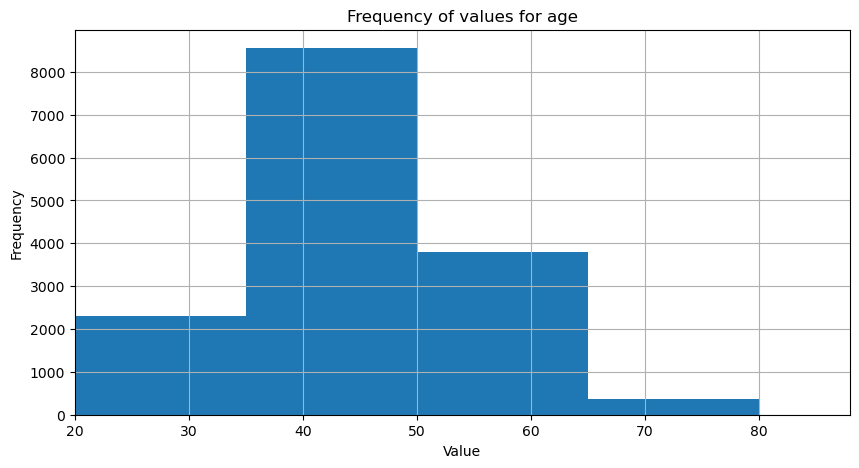

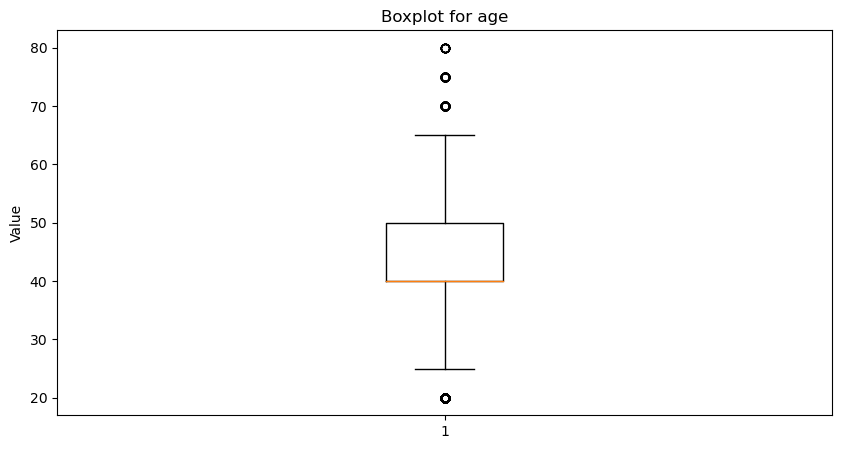

Descriptive statistics:


count    15000.000000
mean        42.606000
std         10.415341
min         20.000000
25%         40.000000
50%         40.000000
75%         50.000000
max         80.000000
Name: age, dtype: float64


Analysis for column: height(cm)


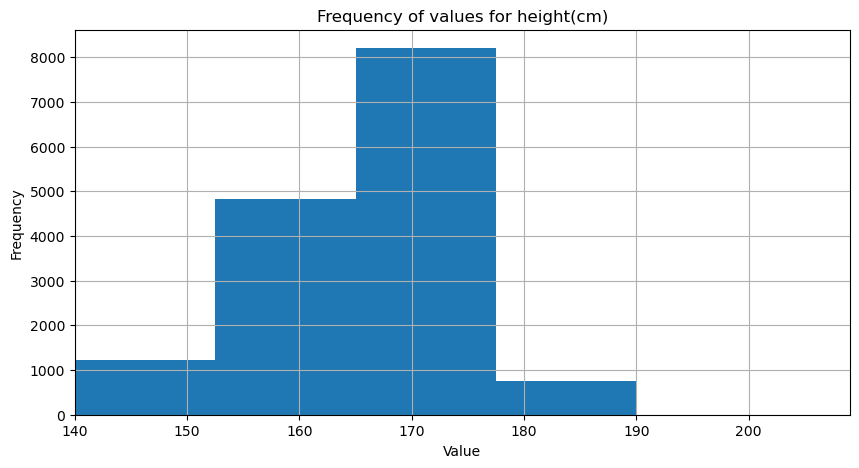

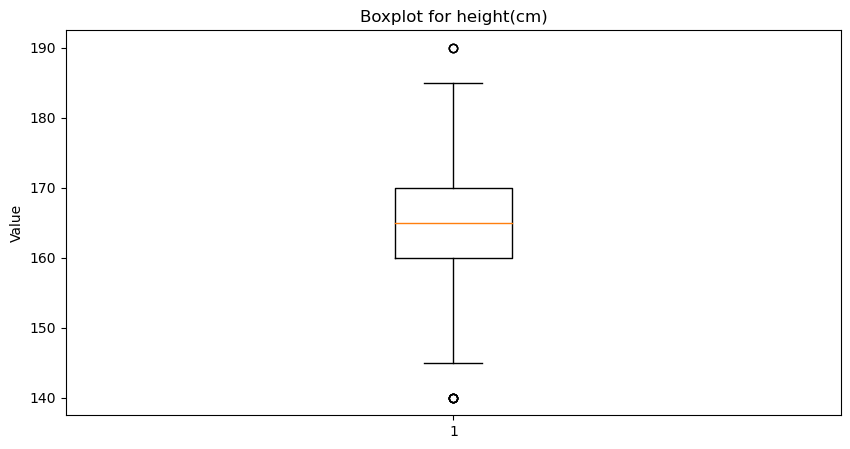

Descriptive statistics:


count    15000.000000
mean       164.672667
std          8.558684
min        140.000000
25%        160.000000
50%        165.000000
75%        170.000000
max        190.000000
Name: height(cm), dtype: float64


Analysis for column: weight(kg)


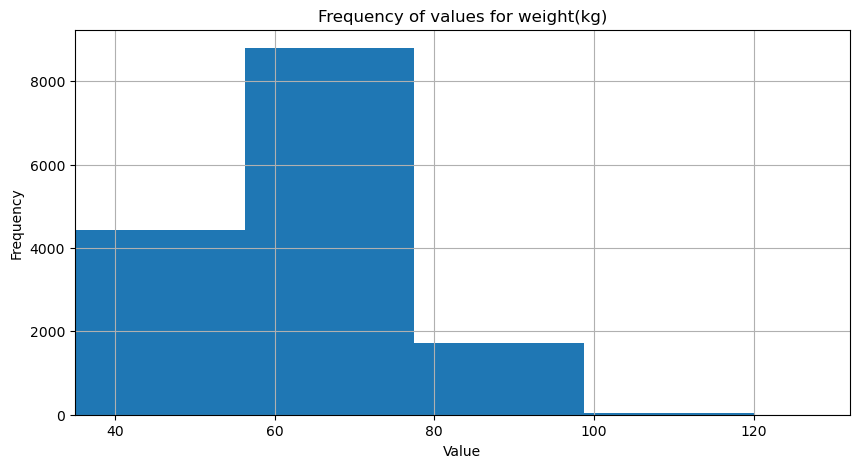

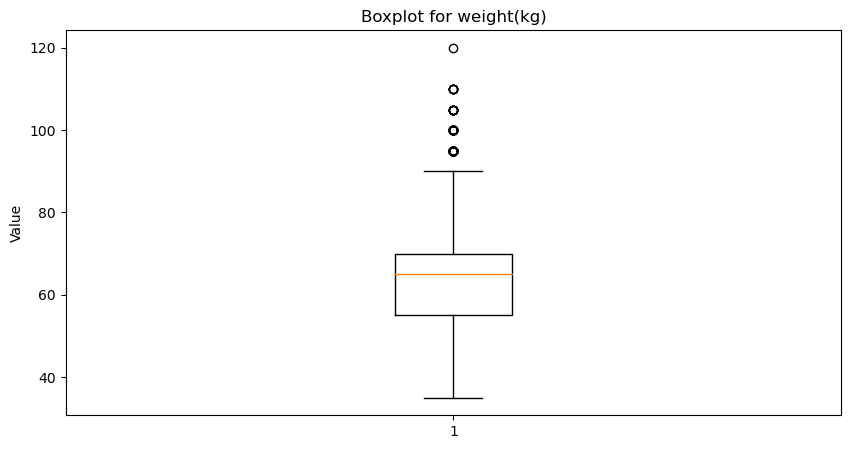

Descriptive statistics:


count    15000.000000
mean        64.282000
std         10.973871
min         35.000000
25%         55.000000
50%         65.000000
75%         70.000000
max        120.000000
Name: weight(kg), dtype: float64


Analysis for column: waist(cm)


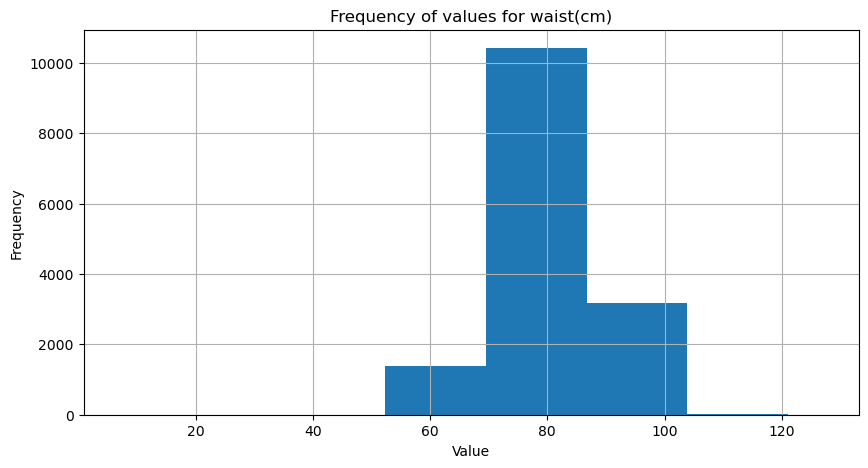

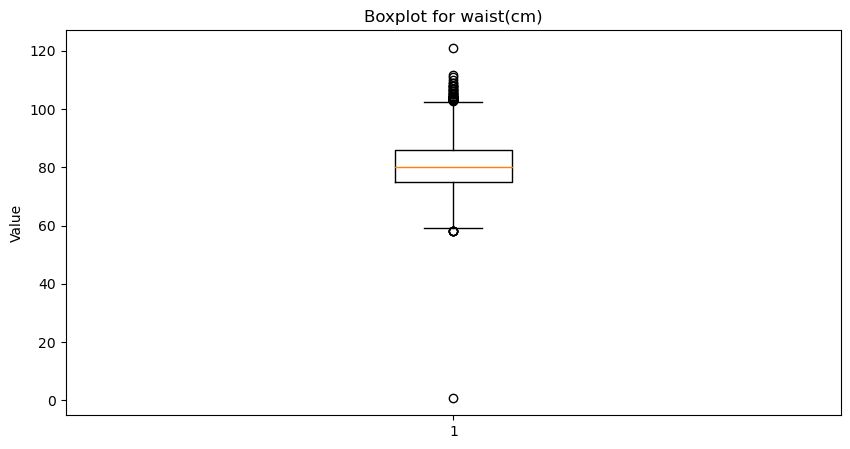

Descriptive statistics:


count    15000.000000
mean        80.323180
std          7.932701
min          0.900000
25%         75.000000
50%         80.000000
75%         86.000000
max        121.000000
Name: waist(cm), dtype: float64


Analysis for column: eyesight(left)


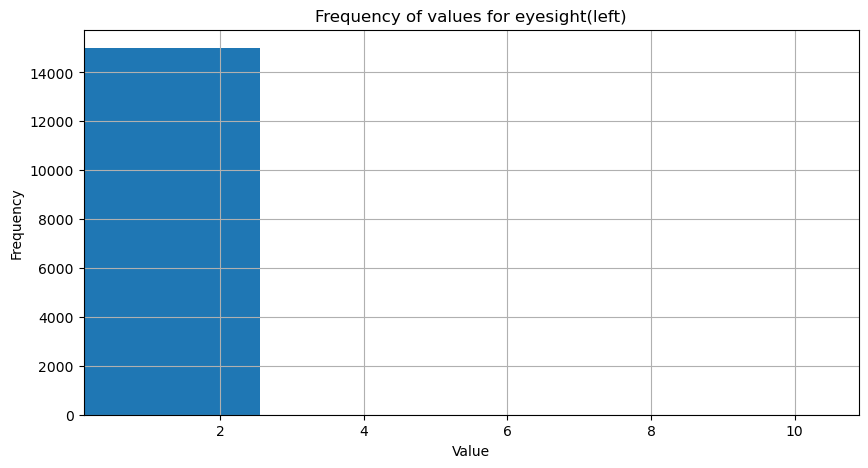

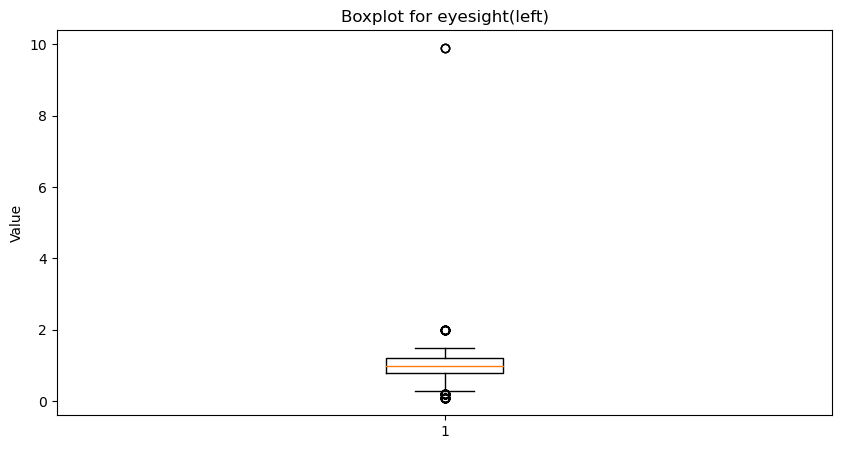

Descriptive statistics:


count    15000.000000
mean         1.032727
std          0.312845
min          0.100000
25%          0.800000
50%          1.000000
75%          1.200000
max          9.900000
Name: eyesight(left), dtype: float64


Analysis for column: eyesight(right)


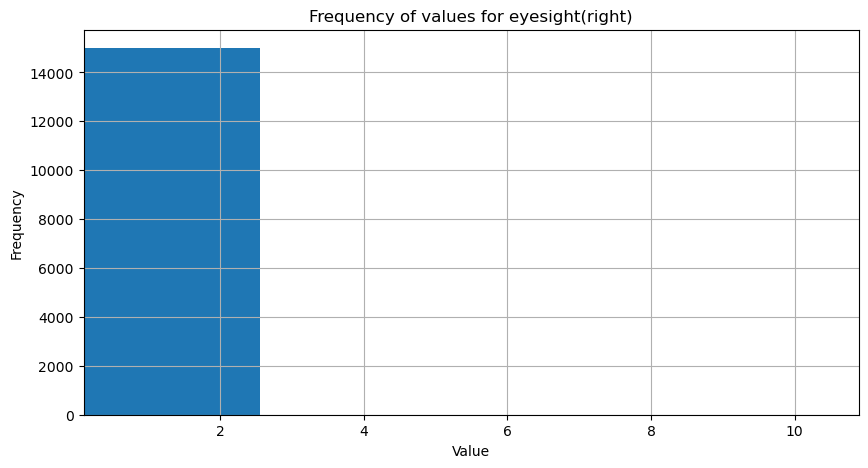

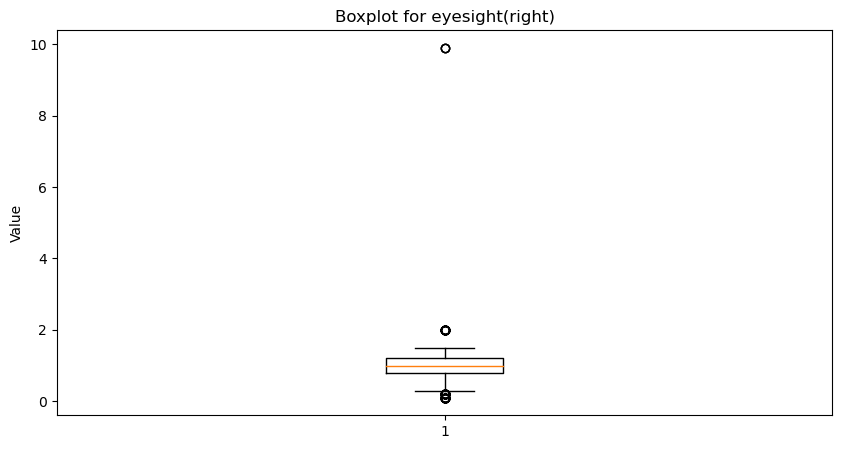

Descriptive statistics:


count    15000.000000
mean         1.025927
std          0.313488
min          0.100000
25%          0.800000
50%          1.000000
75%          1.200000
max          9.900000
Name: eyesight(right), dtype: float64


Analysis for column: hearing(left)


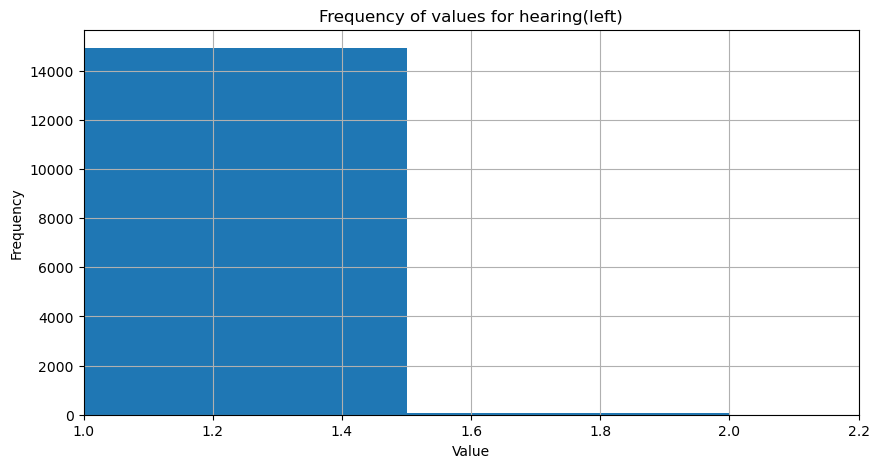

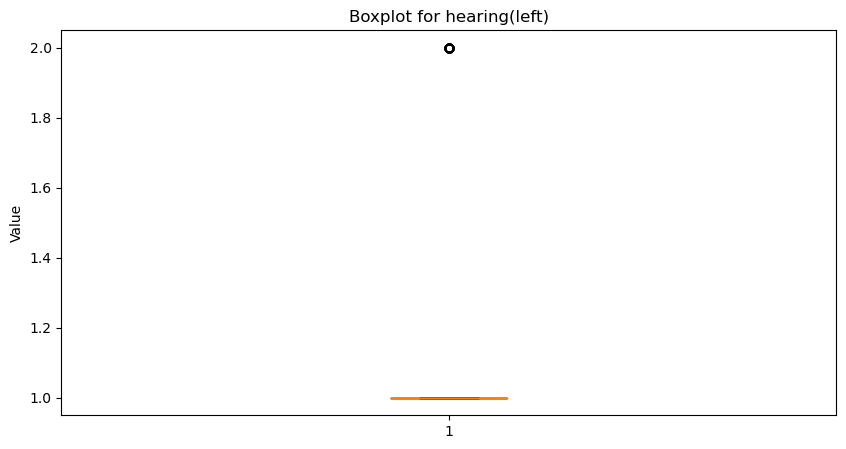

Descriptive statistics:


count    15000.000000
mean         1.005533
std          0.074183
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: hearing(left), dtype: float64


Analysis for column: hearing(right)


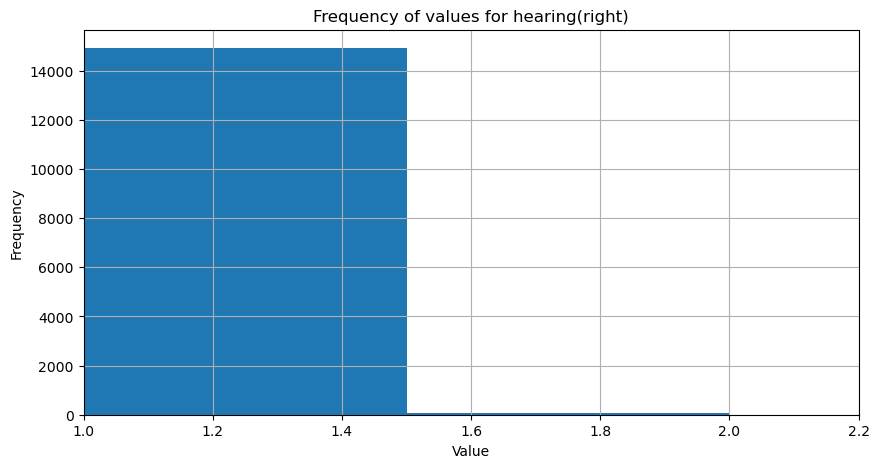

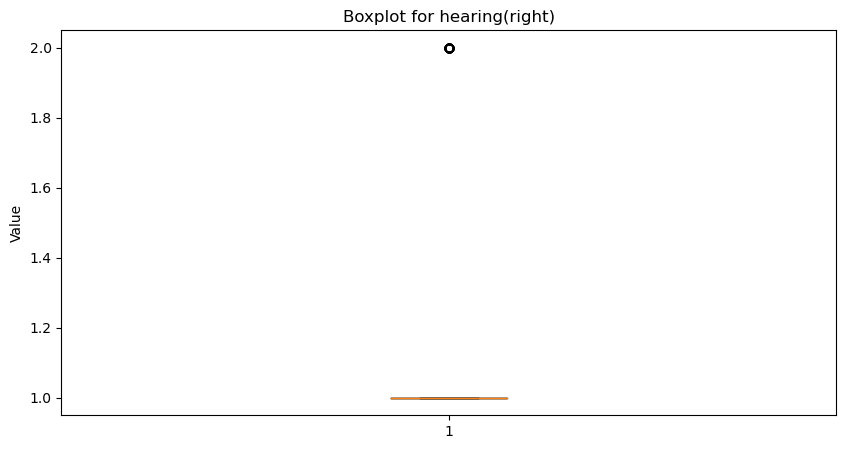

Descriptive statistics:


count    15000.000000
mean         1.004933
std          0.070067
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: hearing(right), dtype: float64


Analysis for column: systolic


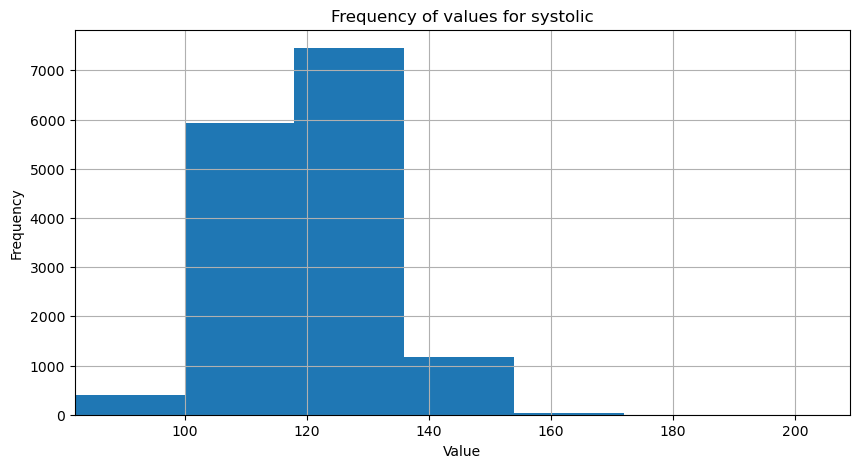

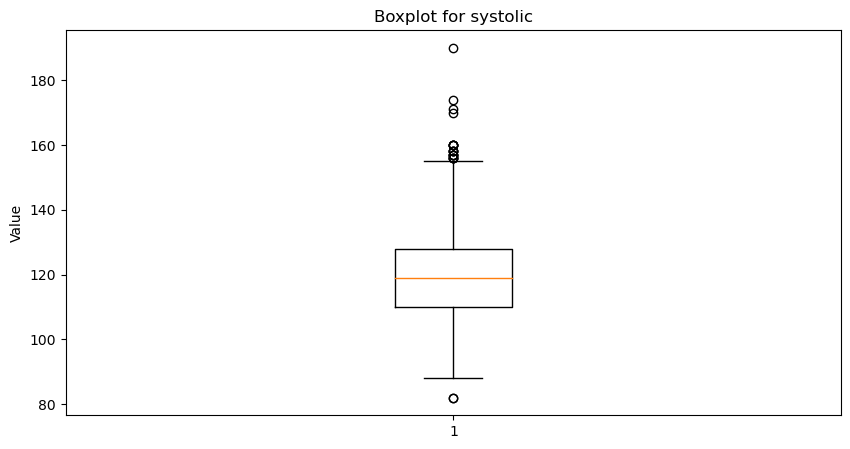

Descriptive statistics:


count    15000.000000
mean       119.149467
std         11.167046
min         82.000000
25%        110.000000
50%        119.000000
75%        128.000000
max        190.000000
Name: systolic, dtype: float64


Analysis for column: relaxation


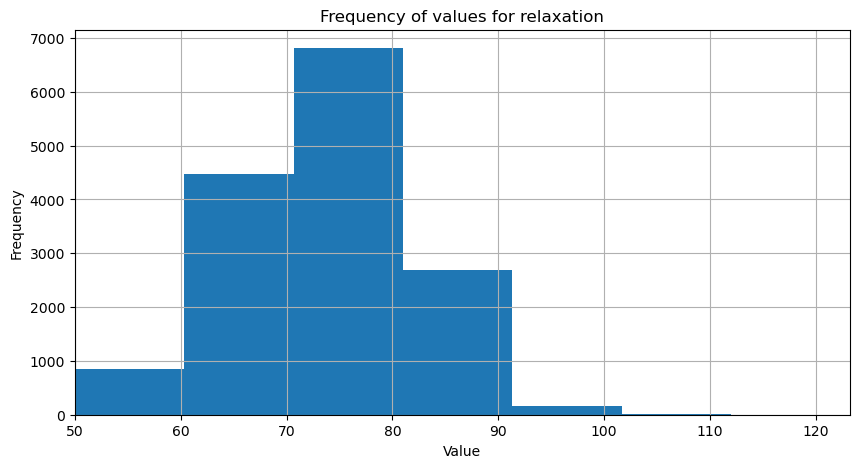

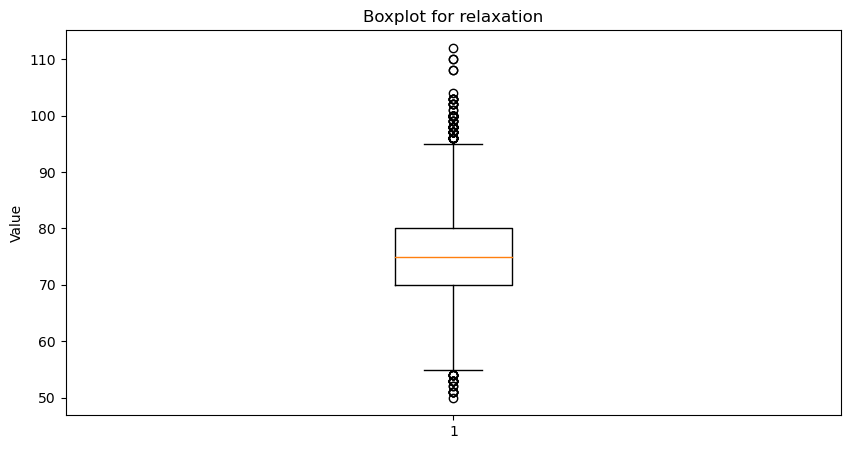

Descriptive statistics:


count    15000.00000
mean        74.78080
std          7.97504
min         50.00000
25%         70.00000
50%         75.00000
75%         80.00000
max        112.00000
Name: relaxation, dtype: float64


Analysis for column: fasting blood sugar


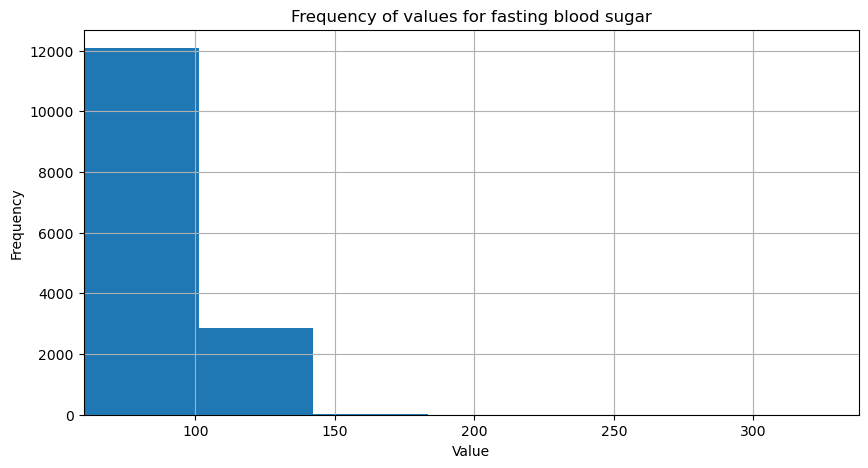

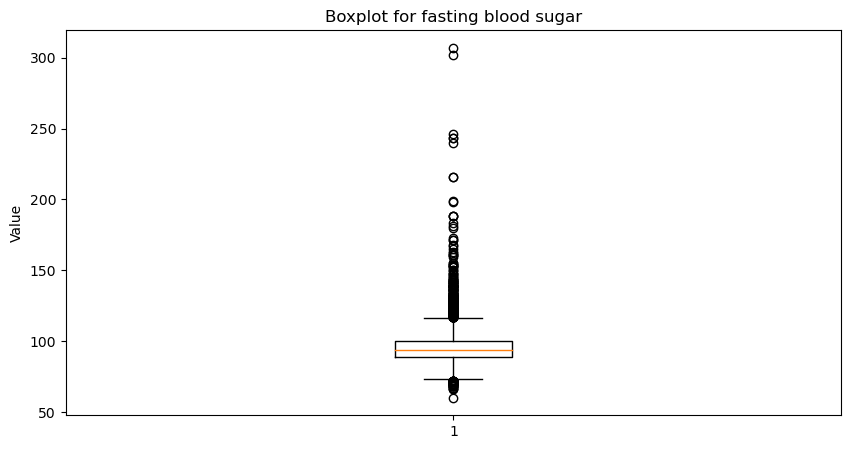

Descriptive statistics:


count    15000.000000
mean        94.992867
std         10.459616
min         60.000000
25%         89.000000
50%         94.000000
75%        100.000000
max        307.000000
Name: fasting blood sugar, dtype: float64


Analysis for column: Cholesterol


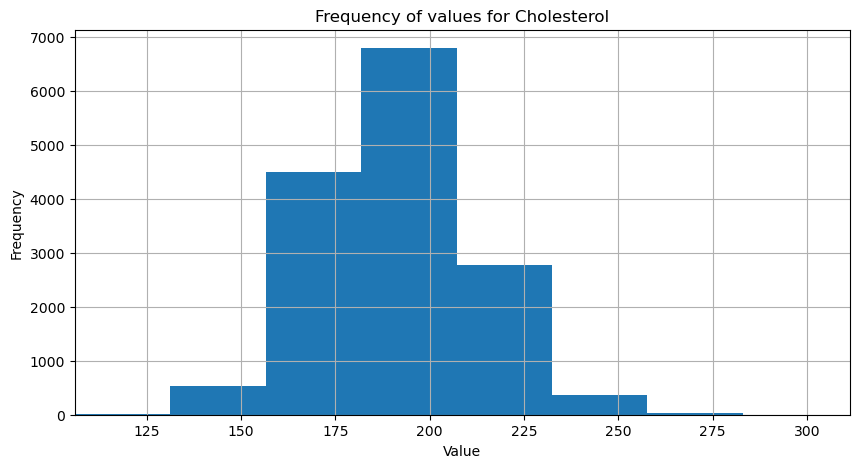

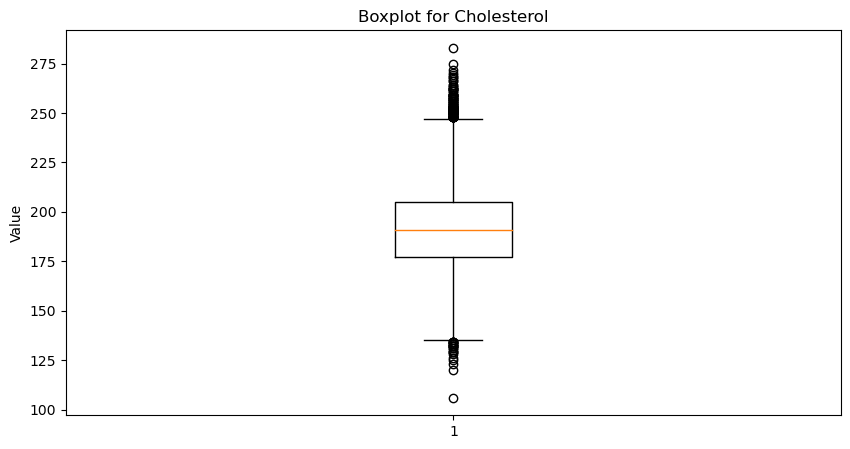

Descriptive statistics:


count    15000.000000
mean       191.212667
std         20.410687
min        106.000000
25%        177.000000
50%        191.000000
75%        205.000000
max        283.000000
Name: Cholesterol, dtype: float64


Analysis for column: triglyceride


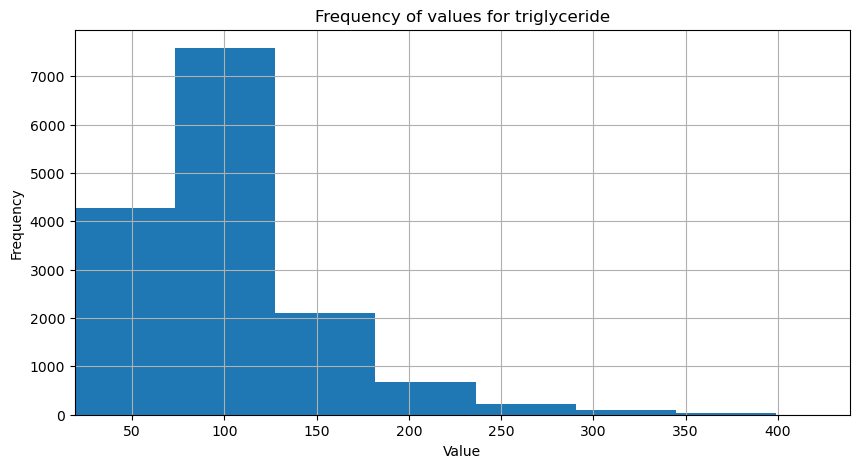

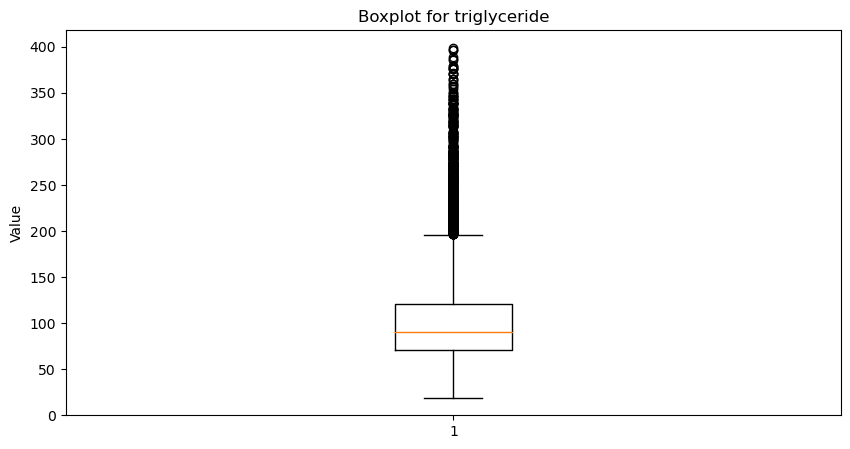

Descriptive statistics:


count    15000.000000
mean       102.229267
std         47.861718
min         19.000000
25%         71.000000
50%         90.000000
75%        121.000000
max        399.000000
Name: triglyceride, dtype: float64


Analysis for column: HDL


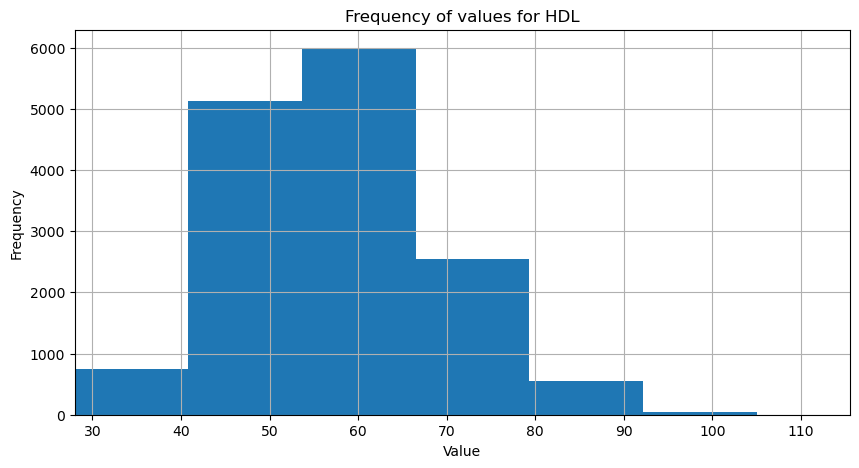

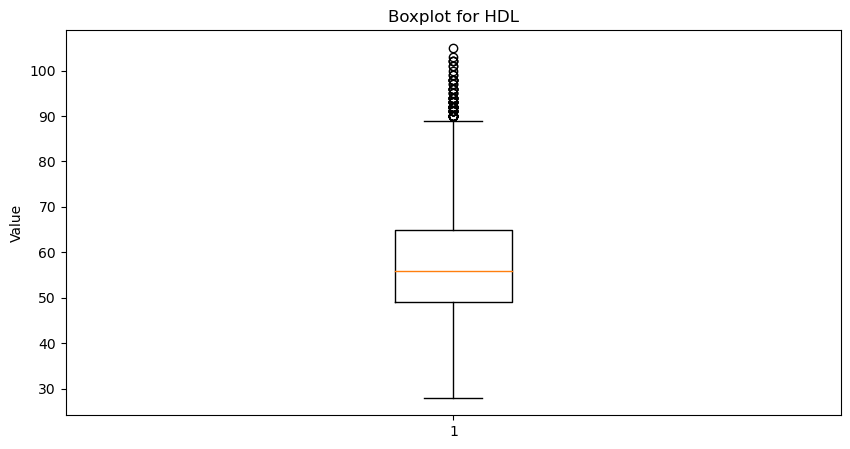

Descriptive statistics:


count    15000.000000
mean        57.535667
std         11.380739
min         28.000000
25%         49.000000
50%         56.000000
75%         65.000000
max        105.000000
Name: HDL, dtype: float64


Analysis for column: LDL


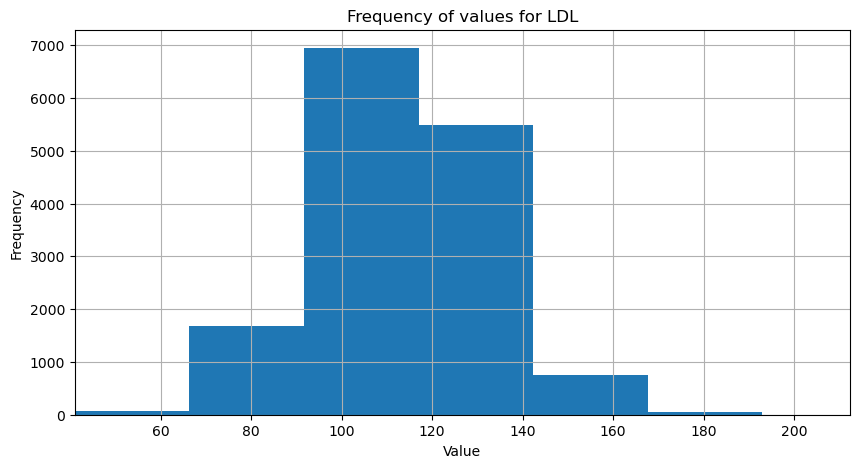

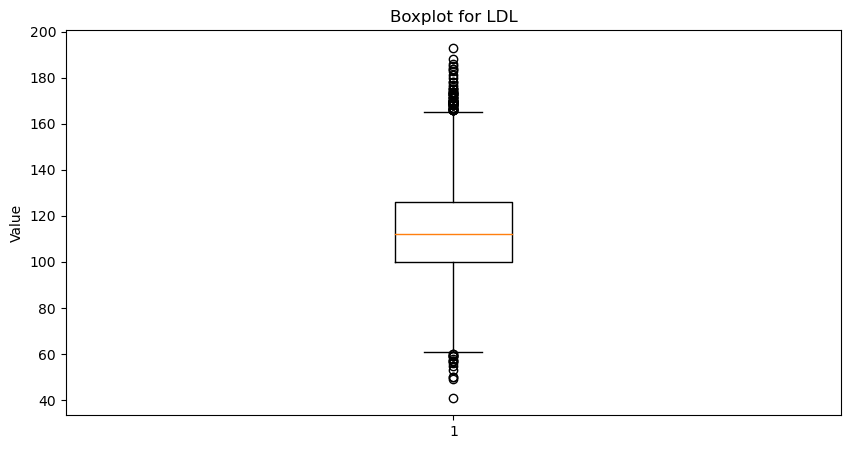

Descriptive statistics:


count    15000.000000
mean       113.158533
std         18.442012
min         41.000000
25%        100.000000
50%        112.000000
75%        126.000000
max        193.000000
Name: LDL, dtype: float64


Analysis for column: hemoglobin


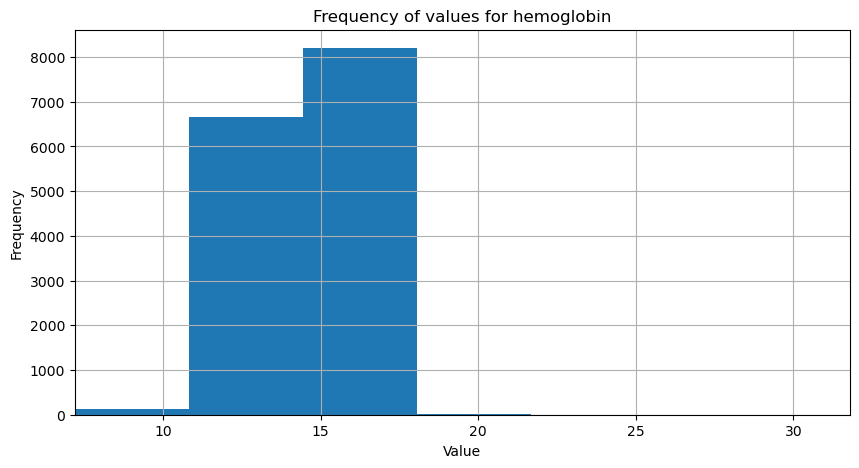

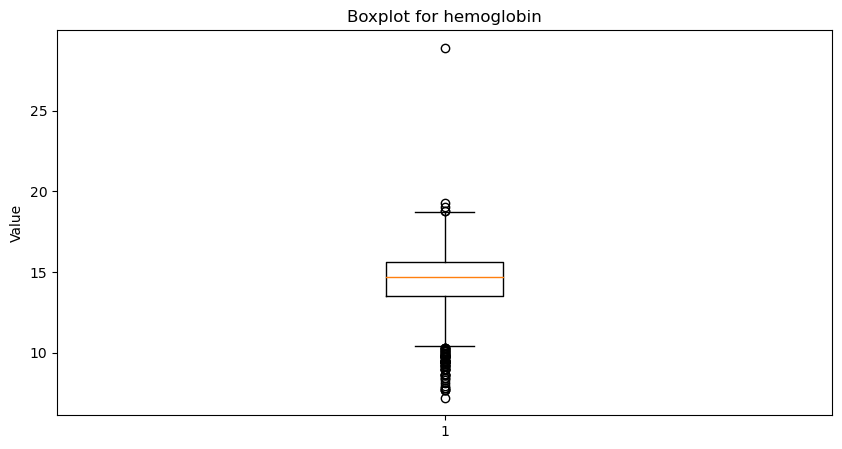

Descriptive statistics:


count    15000.000000
mean        14.510340
std          1.392921
min          7.200000
25%         13.500000
50%         14.700000
75%         15.600000
max         28.900000
Name: hemoglobin, dtype: float64


Analysis for column: Urine protein


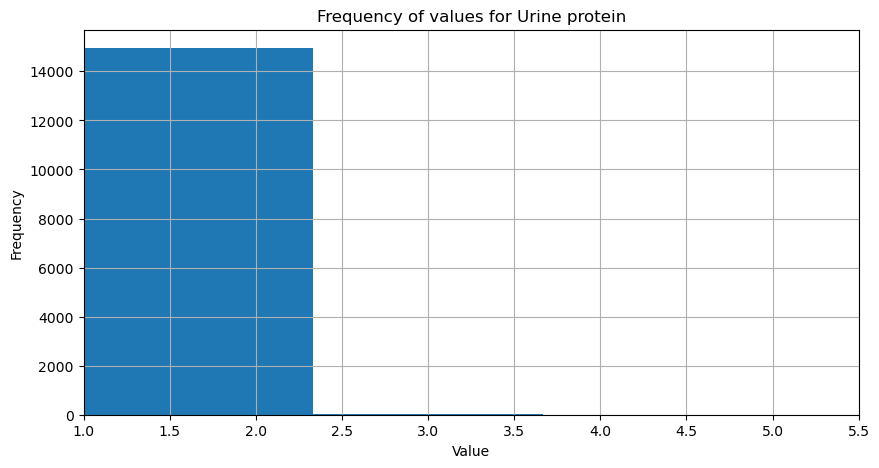

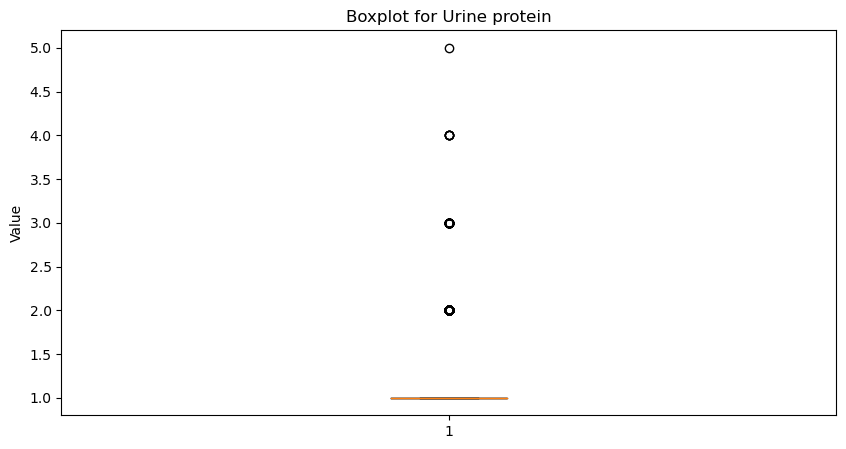

Descriptive statistics:


count    15000.000000
mean         1.016533
std          0.157464
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: Urine protein, dtype: float64


Analysis for column: serum creatinine


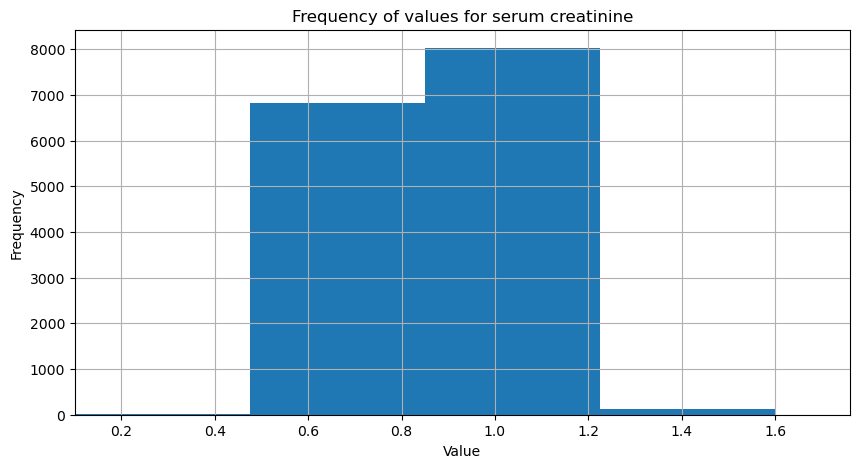

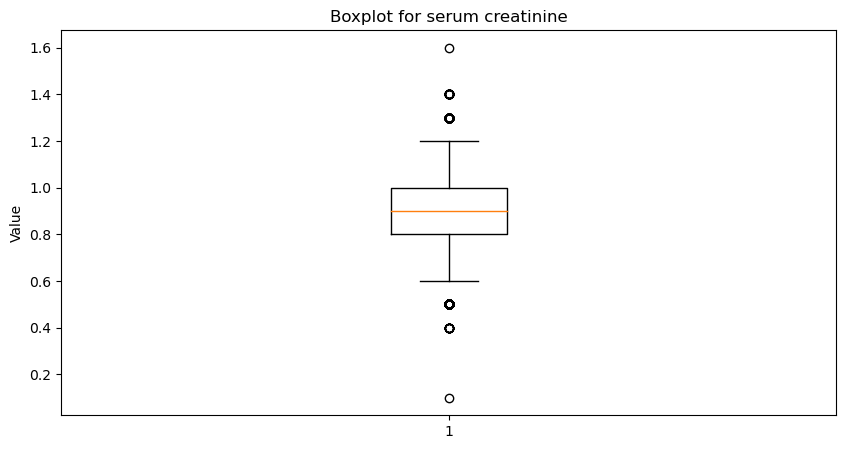

Descriptive statistics:


count    15000.000000
mean         0.866580
std          0.168492
min          0.100000
25%          0.800000
50%          0.900000
75%          1.000000
max          1.600000
Name: serum creatinine, dtype: float64


Analysis for column: AST


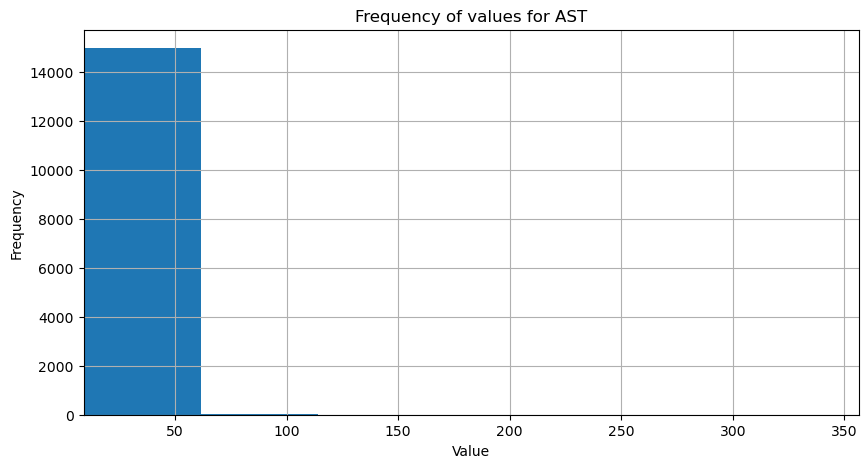

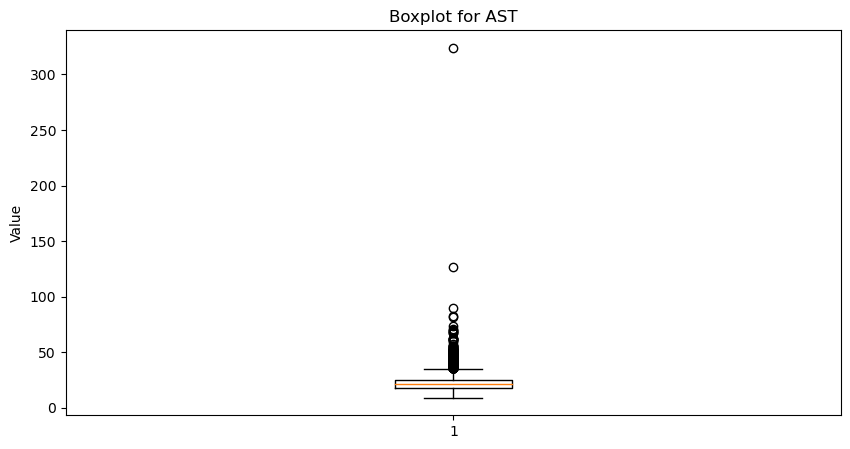

Descriptive statistics:


count    15000.000000
mean        22.272667
std          6.324422
min          9.000000
25%         18.000000
50%         21.000000
75%         25.000000
max        324.000000
Name: AST, dtype: float64


Analysis for column: ALT


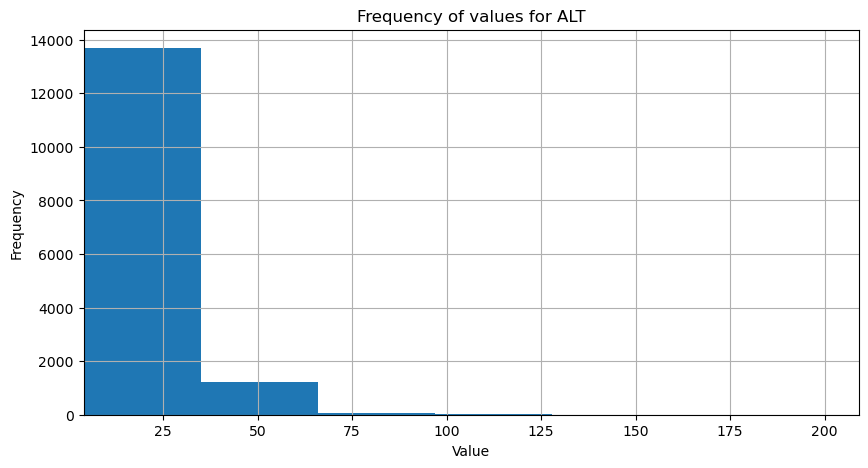

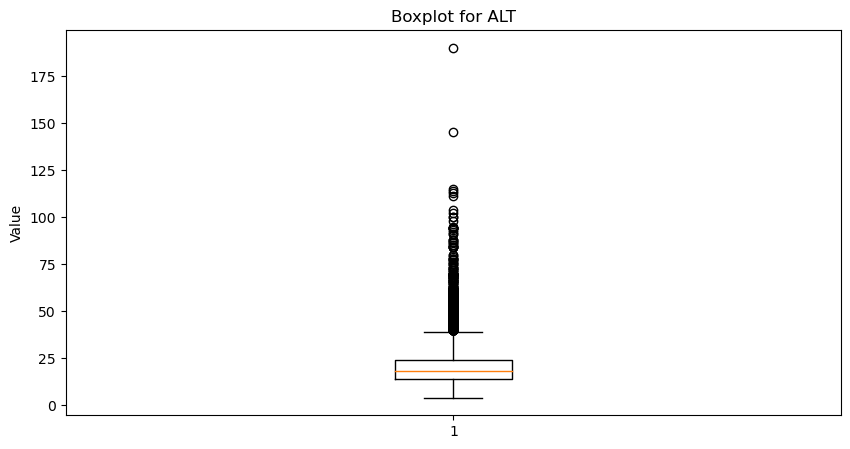

Descriptive statistics:


count    15000.000000
mean        20.874933
std         10.314009
min          4.000000
25%         14.000000
50%         18.000000
75%         24.000000
max        190.000000
Name: ALT, dtype: float64


Analysis for column: Gtp


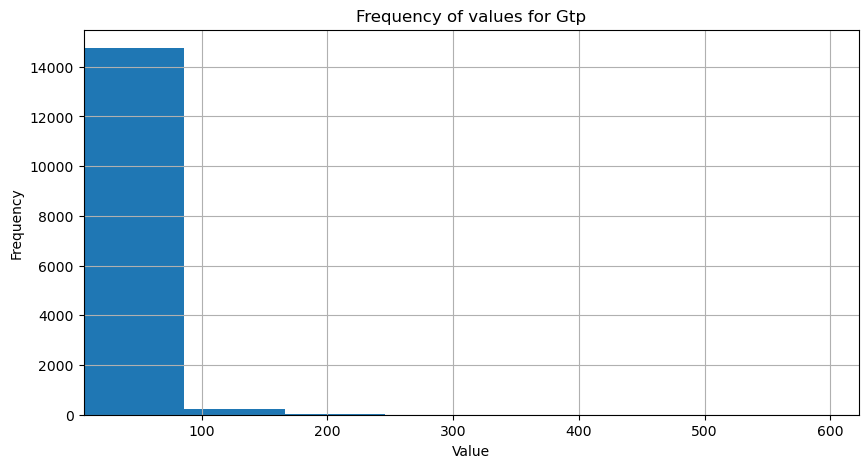

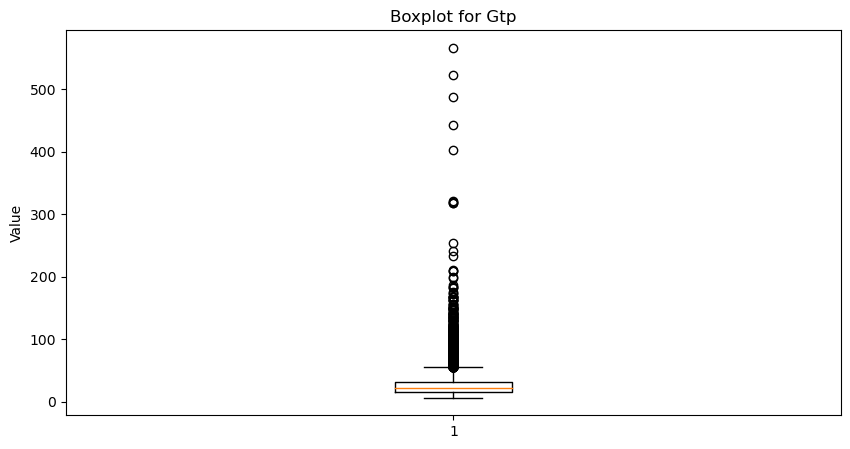

Descriptive statistics:


count    15000.000000
mean        26.290200
std         20.431882
min          6.000000
25%         15.000000
50%         21.000000
75%         31.000000
max        566.000000
Name: Gtp, dtype: float64


Analysis for column: dental caries


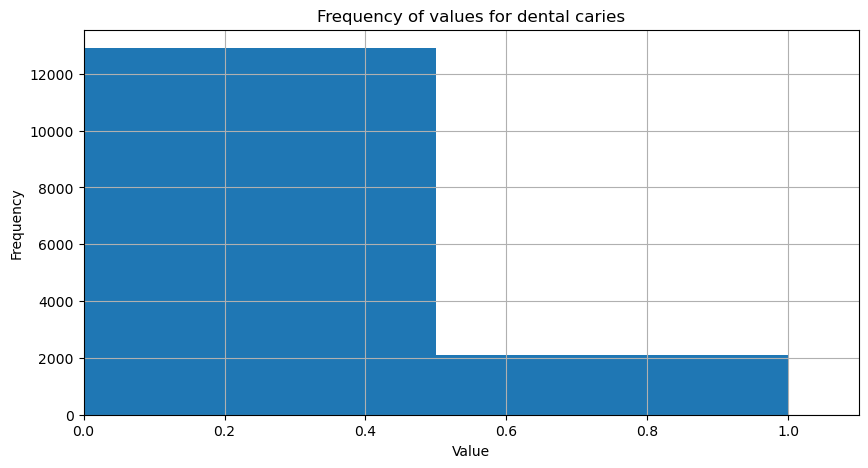

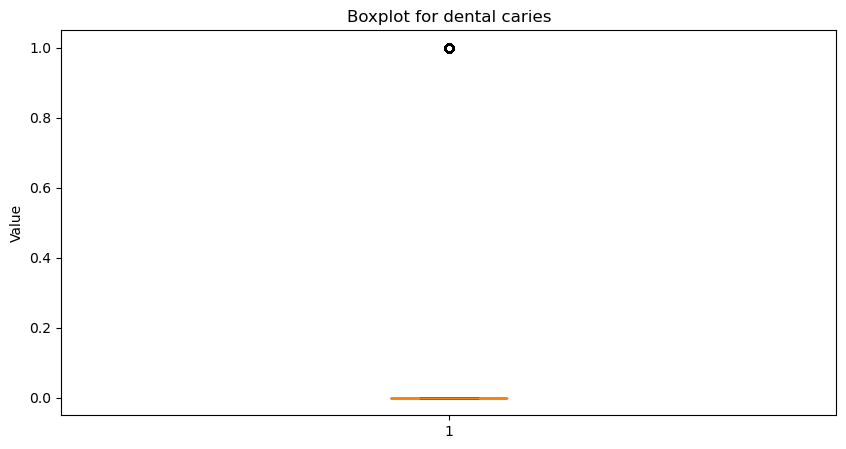

Descriptive statistics:


count    15000.000000
mean         0.139467
std          0.346444
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: dental caries, dtype: float64


Analysis for column: smoking


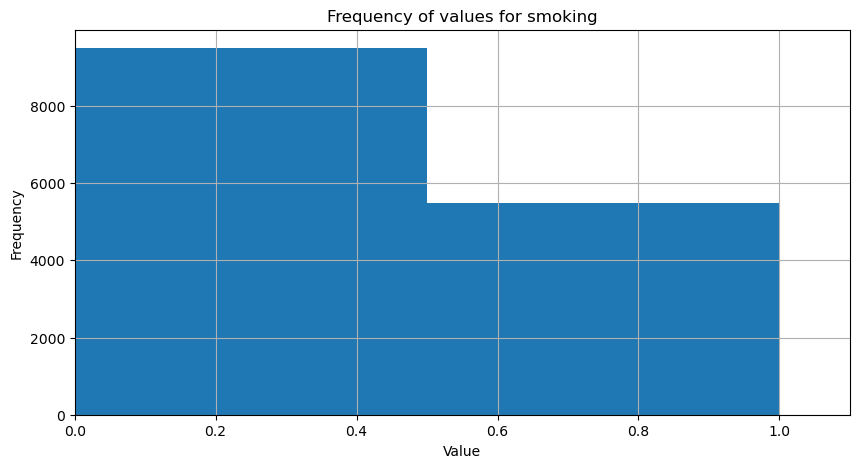

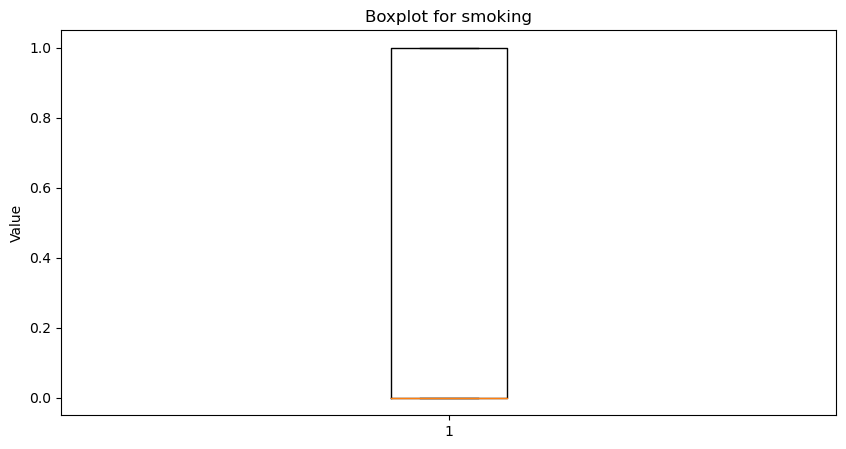

Descriptive statistics:


count    15000.000000
mean         0.366600
std          0.481892
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: smoking, dtype: float64

In [159]:
for col in num_cols:       
    print("\n" + "="*50)
    print(f"Analysis for column: {col}")
        
    plt.figure(figsize=(10, 5))
    train_df[col].hist(bins=math.ceil(np.log(len(train_df[col].unique())) + 1))
    plt.xlim(train_df[col].min(), train_df[col].max() * scale_coef)
    plt.title(f"Frequency of values for {col}")
    plt.ylabel('Frequency')
    plt.xlabel('Value')
    plt.show()
        
    plt.figure(figsize=(10, 5))
    plt.boxplot(train_df[col].dropna())
    plt.title(f"Boxplot for {col}")
    plt.ylabel('Value')
    plt.show()
        
    print("Descriptive statistics:")
    display(train_df[col].describe())

In [160]:
def plot_pairplot(train_df, num_cols, class_column):
    df = train_df[num_cols + [class_column]]
    
    df[class_column] = df[class_column].astype('category')
    
    for i in range(len(num_cols)):
        for j in range(i+1, len(num_cols)):
            pair_df = df[[num_cols[i], num_cols[j], class_column]]
            
            sns.pairplot(pair_df, hue=class_column)
            plt.show() 



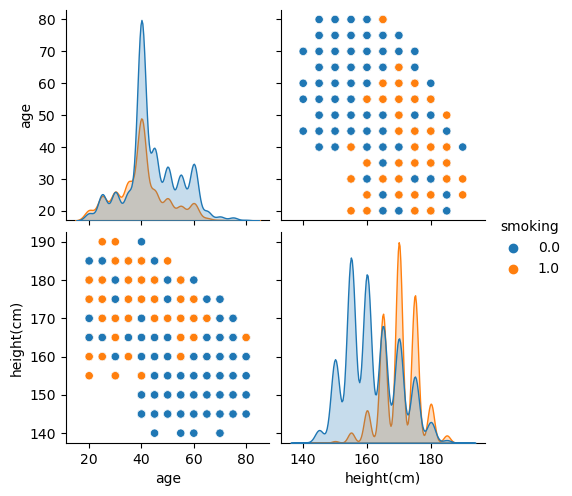

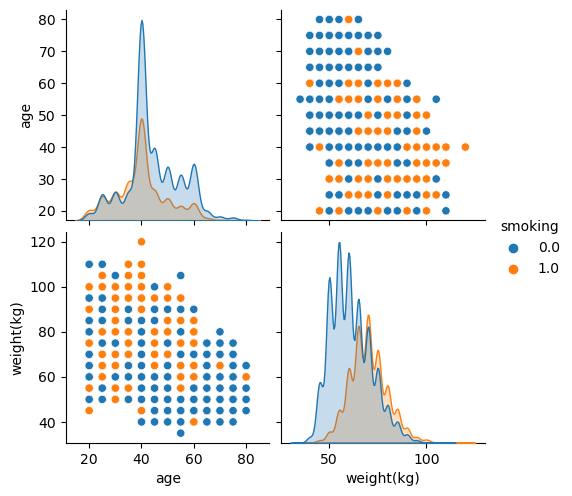

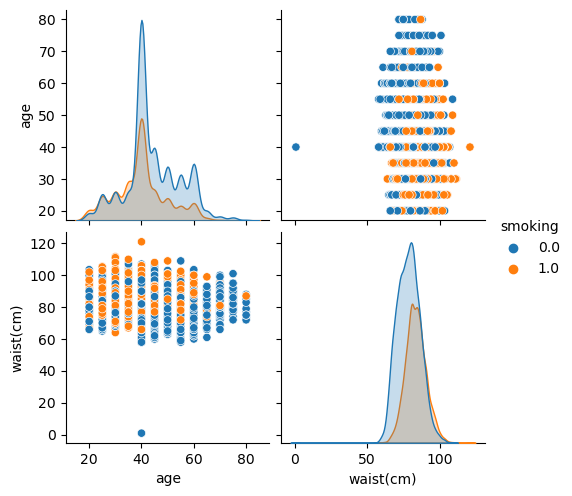

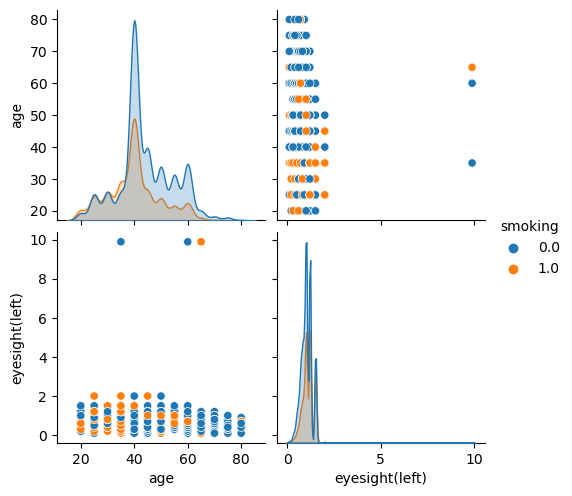

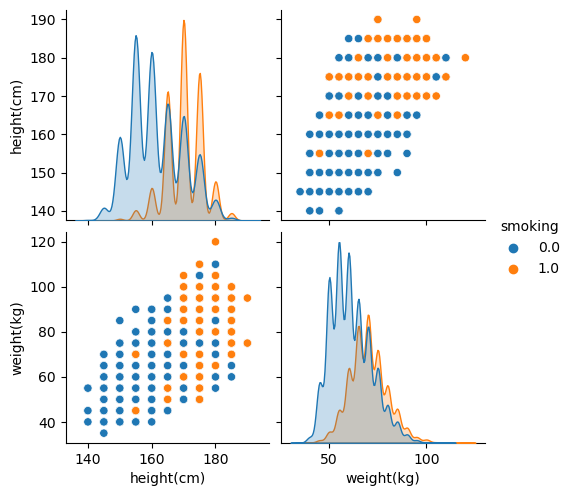

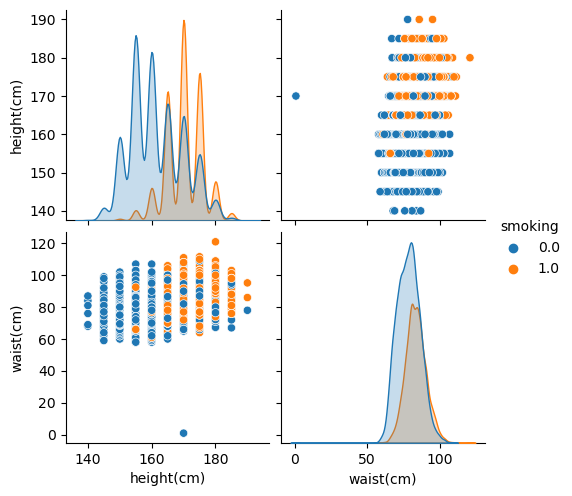

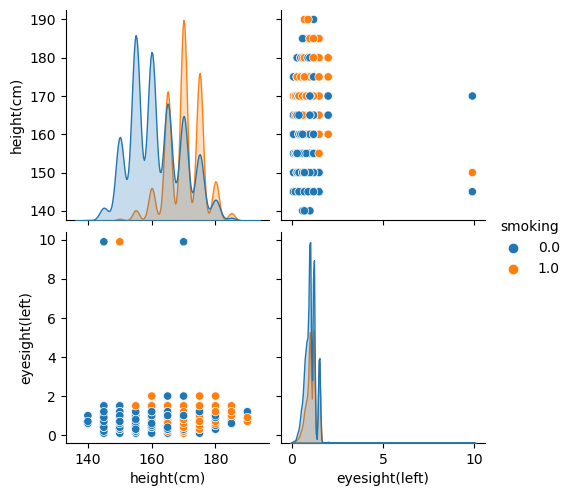

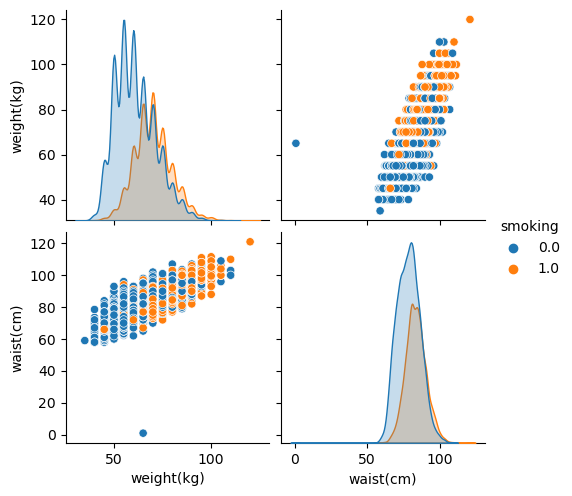

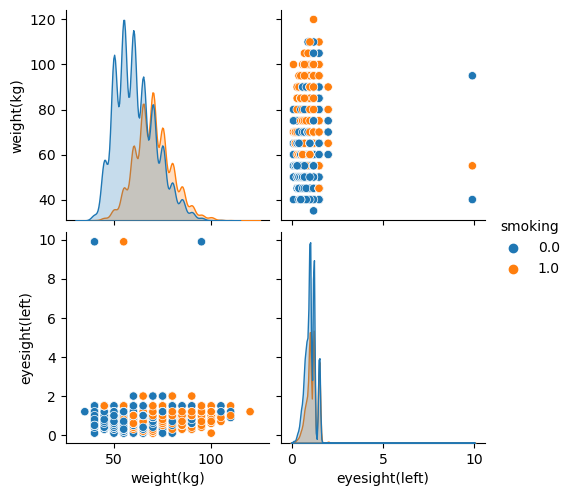

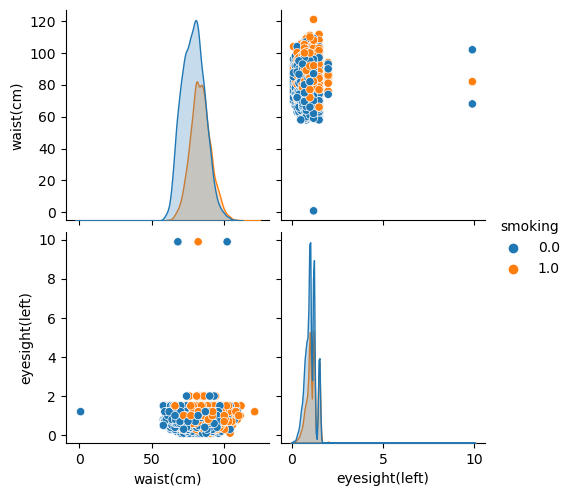

In [161]:
plot_pairplot(train_df, num_cols[:5], 'smoking')

Выборки линейно неразделимые, поэтому использование деревьев тут будет в самый раз

## Корреляционный анализ

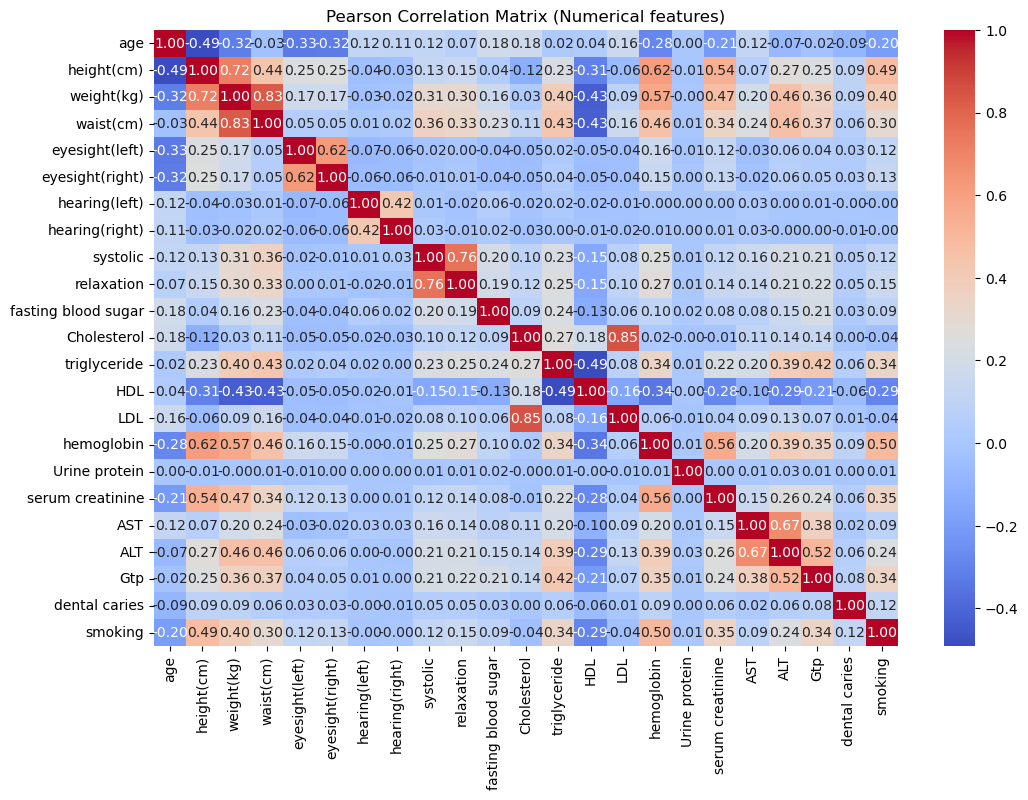

In [183]:
corr_matrix = train_df.corr()

fig, axes = plt.subplots(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', ax=axes)
plt.title('Pearson Correlation Matrix (Numerical features)')

plt.show()

# Отбор признаков

In [163]:
from sklearn.preprocessing import PolynomialFeatures

class FeatureGenerator(BaseEstimator, TransformerMixin):
    def __init__(self, log=True, square=True, interactions=True):
        self.log = log
        self.square = square
        self.interactions = interactions
        self.poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        self.feature_names_in_ = None
        self.numeric_cols_ = None

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = X.columns.tolist()
            self.numeric_cols_ = X.select_dtypes(include=[np.number]).columns.tolist()
        else:
            self.feature_names_in_ = [f'x{i}' for i in range(X.shape[1])]
            self.numeric_cols_ = self.feature_names_in_
        
        if self.interactions:
            self.poly.fit(X[self.numeric_cols_] if isinstance(X, pd.DataFrame) else X)
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        
        results = [X.copy()]
        
        numeric_cols = self.numeric_cols_ if hasattr(self, 'numeric_cols_') else X.select_dtypes(include=[np.number]).columns
        
        if self.square and len(numeric_cols) > 0:
            X_square = X[numeric_cols] ** 2
            X_square.columns = [f'{col}_squared' for col in X_square.columns]
            results.append(X_square)

        if self.log and len(numeric_cols) > 0:
            X_log = np.log1p(np.abs(X[numeric_cols]))
            X_log.columns = [f'{col}_log' for col in X_log.columns]
            results.append(X_log)

        if self.interactions and len(numeric_cols) > 1:
            X_poly = self.poly.transform(X[numeric_cols])
            poly_cols = self.poly.get_feature_names_out(numeric_cols)
            X_poly_df = pd.DataFrame(X_poly, columns=poly_cols, index=X.index)
            
            interaction_cols = [col for col in poly_cols if " " in col]
            interaction_df = X_poly_df[interaction_cols]
            interaction_df.columns = [col.replace(" ", "_x_") for col in interaction_cols]
            
            results.append(interaction_df)

        return pd.concat(results, axis=1)

In [164]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, correlation_threshold=0.9, selection_method='mutual_info', top_n=10):
        self.correlation_threshold = correlation_threshold
        self.selection_method = selection_method
        self.top_n = top_n
    
    def fit(self, X, y=None):
        self.selected_features_ = self._remove_highly_correlated_features(X)
        
        if self.selection_method == 'mutual_info':
            self.final_selected_features_ = self._mutual_information_selection(X, y)
        elif self.selection_method == 'anova':
            self.final_selected_features_ = self._anova_selection(X, y)
        elif self.selection_method == 'correlation':
            self.final_selected_features_ = self.selected_features_
        
        return self
    
    def transform(self, X):
        return X[self.final_selected_features_]
    
    def _remove_highly_correlated_features(self, X):
        corr_matrix = X.corr()
        to_drop = set()
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > self.correlation_threshold:
                    colname = corr_matrix.columns[i]
                    to_drop.add(colname)
        
        selected_features = [col for col in X.columns if col not in to_drop]
        return selected_features
    
    def _mutual_information_selection(self, X, y):
        mi = mutual_info_classif(X, y)
        
        mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi})
        top_features = mi_df.sort_values(by='Mutual Information', ascending=False).head(self.top_n)
        
        return top_features['Feature'].tolist()
    
    def _anova_selection(self, X, y):
        f_values, p_values = f_classif(X, y)
        
        anova_df = pd.DataFrame({'Feature': X.columns, 'F-Value': f_values, 'P-Value': p_values})
        top_features = anova_df.sort_values(by='F-Value', ascending=False).head(self.top_n)
        
        return top_features['Feature'].tolist()



In [165]:
X_train = train_df.drop(columns = ['smoking'], axis = 1)
y_train = train_df['smoking']

f_gen = FeatureGenerator(log=True, square=True, interactions=True)
f_gen.fit(X_train)

X_train_gen = f_gen.fit_transform(X_train)
X_test_gen = f_gen.transform(test_df)

In [166]:
selector = FeatureSelector(correlation_threshold=0.9, selection_method='anova', top_n=20)
selector.fit(X_train_gen, y_train)

X_train_selected = selector.transform(X_train_gen)
X_test_selected = selector.transform(X_test_gen)
X_train_selected.head()

,height(cm)_x_hemoglobin,hemoglobin_squared,hemoglobin,hemoglobin_log,height(cm)_log,height(cm),height(cm)_squared,weight(kg)_x_hemoglobin,waist(cm)_x_hemoglobin,Gtp_log,hemoglobin_x_serum_x_creatinine,height(cm)_x_weight(kg),height(cm)_x_waist(cm),weight(kg)_x_serum_x_creatinine,height(cm)_x_serum_x_creatinine,weight(kg)_log,triglyceride_x_serum_x_creatinine,hearing(right)_x_hemoglobin,triglyceride_x_hemoglobin,weight(kg)
id,,,,,,,,,,,,,,,,,,,,
0,1800.0,144.00,12.0,2.564949,5.017280,150.0,22500.0,600.0,876.00,2.564949,7.20,7500.0,10950.0,30.0,90.0,3.931826,29.4,12.0,588.0,50.0
1,2256.0,198.81,14.1,2.714695,5.081404,160.0,25600.0,846.0,1122.36,2.890372,12.69,9600.0,12736.0,54.0,144.0,4.110874,67.5,14.1,1057.5,60.0
2,1928.5,176.89,13.3,2.660260,4.983607,145.0,21025.0,665.0,970.90,2.639057,7.98,7250.0,10585.0,30.0,87.0,3.931826,43.2,13.3,957.6,50.0
3,2817.5,259.21,16.1,2.839078,5.170484,175.0,30625.0,1288.0,1339.52,3.044522,16.10,14000.0,14560.0,80.0,175.0,4.394449,78.0,16.1,1255.8,80.0
4,2635.0,240.25,15.5,2.803360,5.141664,170.0,28900.0,1085.0,1232.25,3.258097,18.60,11900.0,13515.0,84.0,204.0,4.262680,104.4,15.5,1348.5,70.0


## Обучение моделей

In [167]:
from optuna.distributions import IntDistribution, FloatDistribution, CategoricalDistribution

In [168]:
models = [
    ("LGBM", LGBMClassifier(verbosity=-1, learning_rate=0.05, n_estimators=100)),
    ("XGBoost", XGBClassifier(eval_metric='logloss', learning_rate=0.05, n_estimators=100)),
    ("CatBoost", CatBoostClassifier(logging_level='Silent', learning_rate=0.05, iterations=100)),
    ("MyBagging", MyBagging(base_model=DecisionTreeClassifier(), mode='class', n_estimators=100)),
    ("MyGradientBoosting", MyGradientBoosting(base_model=DecisionTreeClassifier(), mode='class', learning_rate=0.05, n_estimators=100)),
    ("GradientBoosting", GradientBoostingClassifier(learning_rate=0.05, n_estimators=100)),
    ("RandomForest", RandomForestClassifier(n_estimators=100))
]

In [169]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [170]:
results = {}

for name, model in models:
    auc_scores = []
    
    try:
        for train_idx, val_idx in cv.split(X_train_selected, y_train):
            X_train_fold, X_val_fold = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

            model.fit(X_train_fold, y_train_fold)

            y_pred_proba = model.predict_proba(X_val_fold)[:, 1]

            auc_score = roc_auc_score(y_val_fold, y_pred_proba)
            auc_scores.append(auc_score)

        results[name] = np.mean(auc_scores)
        print(f"{name} ROC-AUC: {results[name]:.4f}")
    
    except Exception as e:
        print(f"{name} failed: {e}")

print("\nSummary of ROC-AUC scores on validation set:")
for name, score in results.items():
    print(f"{name}: {score:.4f}")

LGBM ROC-AUC: 0.8720
XGBoost ROC-AUC: 0.8715
CatBoost ROC-AUC: 0.8728
MyBagging ROC-AUC: 0.8584
MyGradientBoosting ROC-AUC: 0.7315
GradientBoosting ROC-AUC: 0.8719
RandomForest ROC-AUC: 0.8601

Summary of ROC-AUC scores on validation set:
LGBM: 0.8720
XGBoost: 0.8715
CatBoost: 0.8728
MyBagging: 0.8584
MyGradientBoosting: 0.7315
GradientBoosting: 0.8719
RandomForest: 0.8601


Обучим три лучших модели с подбором гиперпараметров

In [171]:
models = {
    "LightGBM": {
        "model": LGBMClassifier(verbosity=-1),
        "params": {
            "learning_rate": FloatDistribution(0.005, 0.1),
            "n_estimators": IntDistribution(100, 150)
        }
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric='logloss'),
        "params": {
            "max_depth": IntDistribution(6, 12),
            "learning_rate": FloatDistribution(0.005, 0.1),
            "n_estimators": IntDistribution(100, 150),
            "subsample": FloatDistribution(0.5, 1.0),
            "colsample_bytree": FloatDistribution(0.5, 1.0)
        }
    },
    "CatBoost": {
        "model": CatBoostClassifier(logging_level='Silent'),
        "params": {
            "depth": IntDistribution(6, 15),
            "learning_rate": FloatDistribution(0.005, 0.1),
            "iterations": IntDistribution(100, 500),
            "random_strength": FloatDistribution(0.1, 1.0)
        }
    }
}

In [172]:
best_models = {}

mlflow.set_experiment('model_optimization_experiment')

for name, data in models.items():
    with mlflow.start_run(run_name = name, nested = True):
        print(f"\nOptimizing {name}...")
        
        mlflow.log_params(data["params"])
        
        search = OptunaSearchCV(
            estimator=data["model"],
            param_distributions=data["params"],
            scoring=auc_roc_scorer,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            n_trials=10,
            n_jobs=-1,
            random_state=42
        )
        
        search.fit(X_train_selected, y_train)
        
        mlflow.log_param("best_params", search.best_params_)
        mlflow.log_metric("best_auc_roc", search.best_score_)
        
        mlflow.sklearn.log_model(search.best_estimator_, name)
        
        best_models[name] = search.best_estimator_
        
        print(f"Best params: {search.best_params_}")
        print(f"Best ROC-AUC: {search.best_score_:.4f}")
        
        y_pred_proba = search.best_estimator_.predict_proba(X_train_selected)[:, 1]
        auc_score = roc_auc_score(y_train, y_pred_proba)
        mlflow.log_metric("roc_auc", auc_score)

        accuracy = my_accuracy(y_train, y_pred_proba)
        mlflow.log_metric("accuracy", accuracy)
        
        precision = my_precision(y_train, y_pred_proba)
        mlflow.log_metric("precision", precision)
        
        recall = my_recall(y_train, y_pred_proba)
        mlflow.log_metric("recall", recall)
        
        f1 = my_f1(y_train, y_pred_proba)
        mlflow.log_metric("f1", f1)
        
        auc_pr = my_auc_pr(y_train, y_pred_proba)
        mlflow.log_metric("auc_pr", auc_pr)

print("\nSummary of optimized models and metrics:")
for name, score in best_models.items():
    print(f"{name}: {score}")

[I 2025-05-07 21:26:26,467] A new study created in memory with name: no-name-ff35313a-b477-41cf-9f7c-73f7fdffea5a



Optimizing LightGBM...


[I 2025-05-07 21:26:31,463] Trial 1 finished with value: 0.8705454510684231 and parameters: {'learning_rate': 0.0832666223647565, 'n_estimators': 105}. Best is trial 1 with value: 0.8705454510684231.
[I 2025-05-07 21:26:31,789] Trial 2 finished with value: 0.8724628716936136 and parameters: {'learning_rate': 0.040807372376798524, 'n_estimators': 102}. Best is trial 2 with value: 0.8724628716936136.
[I 2025-05-07 21:26:31,906] Trial 6 finished with value: 0.8696848260180371 and parameters: {'learning_rate': 0.08010876139023036, 'n_estimators': 110}. Best is trial 2 with value: 0.8724628716936136.
[I 2025-05-07 21:26:32,045] Trial 3 finished with value: 0.8694442513417112 and parameters: {'learning_rate': 0.0980829522115537, 'n_estimators': 110}. Best is trial 2 with value: 0.8724628716936136.
[I 2025-05-07 21:26:32,584] Trial 7 finished with value: 0.8723798397244303 and parameters: {'learning_rate': 0.02658116908020873, 'n_estimators': 114}. Best is trial 2 with value: 0.87246287169361

Best params: {'learning_rate': 0.040807372376798524, 'n_estimators': 102}
Best ROC-AUC: 0.8725

Optimizing XGBoost...


[I 2025-05-07 21:26:51,452] Trial 2 finished with value: 0.8665323954933658 and parameters: {'max_depth': 8, 'learning_rate': 0.093799647564172, 'n_estimators': 100, 'subsample': 0.6691808227301033, 'colsample_bytree': 0.7325092393427302}. Best is trial 2 with value: 0.8665323954933658.
[I 2025-05-07 21:26:52,344] Trial 9 finished with value: 0.8705098362520939 and parameters: {'max_depth': 8, 'learning_rate': 0.051869276509240905, 'n_estimators': 106, 'subsample': 0.6517107721245767, 'colsample_bytree': 0.6411188989736127}. Best is trial 9 with value: 0.8705098362520939.
[I 2025-05-07 21:26:52,399] Trial 4 finished with value: 0.8715416431293116 and parameters: {'max_depth': 6, 'learning_rate': 0.014709087156457475, 'n_estimators': 139, 'subsample': 0.9696095192936915, 'colsample_bytree': 0.5232909549878971}. Best is trial 4 with value: 0.8715416431293116.
[I 2025-05-07 21:26:53,919] Trial 0 finished with value: 0.8686888543011142 and parameters: {'max_depth': 9, 'learning_rate': 0.05

Best params: {'max_depth': 8, 'learning_rate': 0.014851558434672472, 'n_estimators': 124, 'subsample': 0.6530619352003595, 'colsample_bytree': 0.7535422906070198}
Best ROC-AUC: 0.8717

Optimizing CatBoost...


[I 2025-05-07 21:27:30,603] Trial 3 finished with value: 0.8721378758696033 and parameters: {'depth': 7, 'learning_rate': 0.03211368396625714, 'iterations': 337, 'random_strength': 0.39889390315032236}. Best is trial 3 with value: 0.8721378758696033.
[I 2025-05-07 21:27:42,861] Trial 4 finished with value: 0.8730330179317758 and parameters: {'depth': 7, 'learning_rate': 0.018714680720282716, 'iterations': 479, 'random_strength': 0.5227710956304013}. Best is trial 4 with value: 0.8730330179317758.
[I 2025-05-07 21:28:41,741] Trial 6 finished with value: 0.8650086261127468 and parameters: {'depth': 10, 'learning_rate': 0.06304859368629497, 'iterations': 356, 'random_strength': 0.43138099770844474}. Best is trial 4 with value: 0.8730330179317758.
[I 2025-05-07 21:28:53,280] Trial 7 finished with value: 0.8630743021954081 and parameters: {'depth': 11, 'learning_rate': 0.08727073869409684, 'iterations': 224, 'random_strength': 0.36903800716741253}. Best is trial 4 with value: 0.873033017931

Best params: {'depth': 7, 'learning_rate': 0.018714680720282716, 'iterations': 479, 'random_strength': 0.5227710956304013}
Best ROC-AUC: 0.8730

Summary of optimized models and metrics:
LightGBM: LGBMClassifier(learning_rate=0.040807372376798524, n_estimators=102,
               verbosity=-1)
XGBoost: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7535422906070198, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.014851558434672472,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,


Лучшая модель - catboost

## Анализ важности

In [173]:
def explain_with_shap(model, X, model_name, save_path):
    plt.figure(figsize=(10, 6))
    
    try:
        if "CatBoost" in model_name:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)
        elif "LightGBM" in model_name or "XGBoost" in model_name:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)
        elif "LogisticRegression" in model_name:
            explainer = shap.LinearExplainer(model, X)
            shap_values = explainer.shap_values(X)
        
        shap.summary_plot(shap_values, X, plot_type="bar", show=False)
        plt.title(f"SHAP Feature Importance - {model_name}")
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()
    except Exception as e:
        print(f"Ошибка в SHAP для {model_name}: {str(e)}")

In [174]:
def plot_feature_importances(model, X, model_name, save_path):
    plt.figure(figsize=(10, 6))
    
    try:
        if "CatBoost" in model_name:
            importances = model.get_feature_importance()
            features = X.columns
        else:
            importances = model.feature_importances_
            features = X.columns
        
        pd.Series(importances, index=features).nlargest(20).plot(kind='barh')
        plt.title(f"Feature Importances - {model_name}")
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()
    except Exception as e:
        print(f"Ошибка в Feature Importances для {model_name}: {str(e)}")


In [175]:
def calculate_permutation_importance(model, X, y, model_name, save_path):
    try:
        result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
        
        importance_df = pd.DataFrame({
            'feature': X.columns,
            'importance_mean': result.importances_mean,
            'importance_std': result.importances_std
        }).sort_values('importance_mean', ascending=False)
        
        plt.figure(figsize=(10, 6))
        importance_df.head(20).plot.barh(x='feature', y='importance_mean', 
                                       xerr='importance_std', legend=False)
        plt.title(f"Permutation Importance - {model_name}")
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()
        
        return importance_df
    except Exception as e:
        print(f"Ошибка в Permutation Importance для {model_name}: {str(e)}")
        return pd.DataFrame()

In [176]:
def ensure_directory_exists(filepath):
    directory = os.path.dirname(filepath)
    if directory and not os.path.exists(directory):
        os.makedirs(directory)

In [177]:
def analyze_and_log_model(best_model, X_train, y_train, name, categorial_cols=None):
    try:
        base_dir = f"analysis_results/{name}"
        shap_path = f"{base_dir}/shap_{name}.png"
        fi_path = f"{base_dir}/feature_importances_{name}.png"
        perm_path = f"{base_dir}/permutation_importance_{name}.png"
        perm_csv_path = f"{base_dir}/permutation_importance_{name}.csv"
        
        ensure_directory_exists(shap_path)
        ensure_directory_exists(fi_path)
        ensure_directory_exists(perm_path)
        ensure_directory_exists(perm_csv_path)
        
        if "CatBoost" in name:
            train_data = Pool(data=X_train, label=y_train, cat_features=categorial_cols)
            
            explain_with_shap(best_model, train_data, name, shap_path)
            
            plot_feature_importances(best_model, X_train, name, fi_path)
            
            perm_importance = calculate_permutation_importance(
                best_model, 
                X_train, 
                y_train, 
                name, 
                perm_path
            )
            model = best_model
        
        else:
            preprocessor = best_model.named_steps['preprocessor']
            model = best_model.named_steps['model']
            X_train_transformed = preprocessor.transform(X_train)
            
            if hasattr(preprocessor, 'get_feature_names_out'):
                feature_names = preprocessor.get_feature_names_out()
                X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names)
            
            explain_with_shap(model, X_train_transformed, name, shap_path)
            
            if hasattr(model, 'feature_importances_'):
                plot_feature_importances(model, X_train_transformed, name, fi_path)
            
            perm_importance = calculate_permutation_importance(
                model, X_train_transformed, y_train, name, perm_path)
        
        perm_importance.to_csv(perm_csv_path, index=False)
        
        mlflow.log_artifact(shap_path)
        mlflow.log_artifact(fi_path) if hasattr(model, 'feature_importances_') or "CatBoost" in name else None
        mlflow.log_artifact(perm_path)
        mlflow.log_artifact(perm_csv_path)
        
        return perm_importance
        
    except Exception as e:
        print(f"Ошибка при анализе модели {name}: {str(e)}")
        return None

In [178]:
best_model = best_models['CatBoost']

In [179]:
with mlflow.start_run(run_name=f"Feature_Analysis_{name}"):
        
    analyze_and_log_model(
        best_model=best_model,
        X_train=X_train_selected,  
        y_train=y_train,
        name=name,
        categorial_cols=[]
    )
        
    mlflow.set_tags({
        "model_type": name,
        "analysis": "feature_importance",
        "stage": "analysis"
    })
        
    print(f"Анализ признаков для модели {name} завершен и залогирован")

2025/05/07 21:42:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run Feature_Analysis_CatBoost at: http://mlflow-service:5000/#/experiments/623128715119408157/runs/0a4a9a322ef2468499b6e9d94efee108.
2025/05/07 21:42:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-service:5000/#/experiments/623128715119408157.


Анализ признаков для модели CatBoost завершен и залогирован


<Figure size 1000x600 with 0 Axes>

# Предсказание

In [180]:
pred = best_model.predict_proba(X_test_selected)[:, 1]

In [181]:
pred_df = pd.DataFrame(pred)
pred_df.columns = ['smoking']
pred_df.index = solution_df.index
pred_df.to_csv('prediction.csv', index=True, index_label='id') 

In [182]:
pred_df

,smoking
id,
15000,0.030893
15001,0.691337
15002,0.333499
15003,0.744307
15004,0.016603
...,...
24995,0.025493
24996,0.272759
24997,0.708254
